In [1]:
import os
import argparse
import time
import datetime
from tqdm import tqdm

from munch import Munch
from torch.backends import cudnn
import torch
import torch.nn.functional as F
import numpy as np

from core.my_loader import get_train_loader, get_test_loader, InputFetcher
from core.my_solver import Solver
from torchvision.transforms import Compose, Resize, Normalize, ToTensor
from torchvision.datasets import ImageFolder
from torch.utils.data import Subset, DataLoader

from easydict import EasyDict as edict
from core.my_solver import compute_d_loss, compute_g_loss, moving_average, adv_loss, r1_reg, Sampler, LoaderSampler, tensor2img
from core.my_metrics import get_Z_pushed_loader_stats, calculate_cost
from core.fid_score import calculate_frechet_distance

from IPython.display import clear_output
import matplotlib.pyplot as plt

os.environ['CUDA_VISIBLE_DEVICES'] = "3"

def str2bool(v):
    return v.lower() in ('true')


def subdirs(dname):
    return [d for d in os.listdir(dname)
            if os.path.isdir(os.path.join(dname, d))]

lambda_id = 50.0

args = edict({
    'img_size': 64,
    'num_domains': 2,
    'latent_dim': 16,
    'hidden_dim': 512,
    'style_dim': 64, 
    'lambda_reg': 1.0,
    'lambda_cyc': 1.0,
    'lambda_sty': 1.0,
    'lambda_ds': 1.0,
    'lambda_id': lambda_id,
    'ds_iter': 100000,
    'w_hpf': -1.0,
    'randcrop_prob': 0.5,
    'total_iters': 100000,
    'resume_iter': 0,
    'batch_size': 16,
    'val_batch_size': 32,
    'lr': 1e-4,
    'f_lr': 1e-6,
    'beta1': 0.0,
    'beta2': 0.99,
    'weight_decay': 1e-4,
    'num_outs_per_domain': 10,
    'mode': 'train', 
    'num_workers': 4,
    'seed': 777,
    'train_img_dir': '/cache/selikhanovych/OT_competitors/stargan-v2/data/celeba2anime_train',
    'val_img_dir': '/cache/selikhanovych/OT_competitors/stargan-v2/data/celeba2anime_test',
    'sample_dir': 'expr/samples',
    'checkpoint_dir': f'/cache/selikhanovych/OT_competitors/stargan-v2/celeba2anime_exps/checkpoints_lambda_{lambda_id}',
    'eval_dir': 'expr/eval',
    'result_dir': 'expr/results',
    'src_dir': 'assets/representative/celeba_hq/src',
    'ref_dir': 'assets/representative/celeba_hq/ref',
    'inp_dir': 'assets/representative/custom/female',
    'out_dir': 'assets/representative/celeba_hq/src/female',
    'wing_path': 'expr/checkpoints/wing.ckpt',
    'lm_path': 'expr/checkpoints/celeba_lm_mean.npz',
    'print_every': 10,
    'sample_every': 4000,
    'save_every': 4000,
    'eval_every': 4000,
    
    'target_dataset': 'aligned_anime_faces',
    'OUTPUT_PATH': f'/cache/selikhanovych/OT_competitors/stargan-v2/celeba2anime_exps/checkpoints_lambda_{lambda_id}',
    'domains': {
        'source': 'celeba_female',
        'target': 'aligned_anime_faces',
    },
    'train_a': '/cache/selikhanovych/OT_competitors/stargan-v2/data/celeba2anime_train/celeba_female',
    'train_b': '/cache/selikhanovych/OT_competitors/stargan-v2/data/celeba2anime_train/aligned_anime_faces', 
    'test_a': '/cache/selikhanovych/OT_competitors/stargan-v2/data/celeba2anime_test/celeba_female',
    'test_b': '/cache/selikhanovych/OT_competitors/stargan-v2/data/celeba2anime_test/aligned_anime_faces',
    
    'n_epochs': 1
})

os.system(f"mkdir -p {args.OUTPUT_PATH}")
os.system(f"mkdir -p {args.checkpoint_dir}")


eval_trg_domain = args.domains['target']
eval_src_domain = args.domains['source']

domains = os.listdir(args.val_img_dir)
domains.sort()

final_trg_index = -1
final_src_index = -1

for trg_idx, trg_domain in enumerate(domains):
    src_domains = [x for x in domains if x != trg_domain]
    for src_idx, src_domain in enumerate(src_domains):
        if src_domain == eval_src_domain and trg_domain == eval_trg_domain:
            final_trg_index = trg_idx
            final_src_index = src_idx
            
print(final_trg_index, final_src_index)

cudnn.benchmark = True
torch.manual_seed(args.seed)

solver = Solver(args)

assert len(subdirs(args.train_img_dir)) == args.num_domains
assert len(subdirs(args.val_img_dir)) == args.num_domains

loaders = Munch(src=get_train_loader(root=args.train_img_dir,
                                     which='source',
                                     img_size=args.img_size,
                                     batch_size=args.batch_size,
                                     num_workers=args.num_workers),
                ref=get_train_loader(root=args.train_img_dir,
                                     which='reference',
                                     img_size=args.img_size,
                                     batch_size=args.batch_size,
                                     num_workers=args.num_workers),
                val=get_test_loader(root=args.val_img_dir,
                                    img_size=args.img_size,
                                    batch_size=args.val_batch_size,
                                    shuffle=False,
                                    num_workers=args.num_workers))

device = 'cuda'

args = solver.args
nets = solver.nets
nets_ema = solver.nets_ema
optims = solver.optims

transform = Compose([Resize((args.img_size, args.img_size)),
                     ToTensor(),
                     Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

train_dataset_a = ImageFolder(args.train_a, transform)
train_dataset_b = ImageFolder(args.train_b, transform)
test_dataset_a = ImageFolder(args.test_a, transform)
test_dataset_b = ImageFolder(args.test_b, transform)

train_loader_a = DataLoader(dataset=train_dataset_a,
                            batch_size=20,
                            num_workers=4,
                            pin_memory=True,
                            shuffle=False)

train_loader_b = DataLoader(dataset=train_dataset_b,
                            batch_size=20,
                            num_workers=4,
                            pin_memory=True,
                            shuffle=False)

test_loader_a = DataLoader(dataset=test_dataset_a,
                           batch_size=20,
                           num_workers=4,
                           pin_memory=True,
                           shuffle=False)

test_loader_b = DataLoader(dataset=test_dataset_b,
                           batch_size=20,
                           num_workers=4,
                           pin_memory=True,
                           shuffle=False)

X_sampler = LoaderSampler(train_loader_a)
X_test_sampler = LoaderSampler(test_loader_a)
Y_sampler = LoaderSampler(train_loader_b)
Y_test_sampler = LoaderSampler(test_loader_b)


torch.manual_seed(0xBADBEEF)
np.random.seed(0xBADBEEF)
solver.X_fixed = X_sampler.sample(10)
solver.Y_fixed = Y_sampler.sample(10)

solver.X_test_fixed = X_test_sampler.sample(10)
solver.Y_test_fixed = Y_test_sampler.sample(10)

# fetch random validation images for debugging
fetcher = InputFetcher(loaders.src, loaders.ref, args.latent_dim, 'train')
fetcher_val = InputFetcher(loaders.val, None, args.latent_dim, 'val')
inputs_val = next(fetcher_val)

# resume training if necessary
if args.resume_iter > 0:
    solver._load_checkpoint(args.resume_iter)

# remember the initial value of ds weight
initial_lambda_ds = args.lambda_ds

eval_trg_domain = args.domains['target']
eval_src_domain = args.domains['source']

domains = os.listdir(args.val_img_dir)
domains.sort()
num_domains = len(domains)
for trg_idx, trg_domain in enumerate(domains):
    src_domains = [x for x in domains if x != trg_domain]
    for src_idx, src_domain in enumerate(src_domains):
        if src_domain == eval_src_domain and trg_domain == eval_trg_domain:
            print(f"trg_idx = {trg_idx}, trg_domain = {trg_domain}, src_domain = {src_domain}")
            break
    break
                    
print(f"trg_idx = {trg_idx}, lambda_id = {args.lambda_id}")

0 0
Number of parameters of generator: 32634883
Number of parameters of mapping_network: 2438272
Number of parameters of style_encoder: 20327808
Number of parameters of discriminator: 20263170
Initializing generator...
Initializing mapping_network...
Initializing style_encoder...
Initializing discriminator...
Preparing DataLoader to fetch source images during the training phase...
Preparing DataLoader to fetch reference images during the training phase...
Preparing DataLoader for the generation phase...
trg_idx = 0, trg_domain = aligned_anime_faces, src_domain = celeba_female
trg_idx = 0, lambda_id = 50.0


Computing l1 cost


591it [00:29, 20.25it/s]


l1 cost = 0.04956008477758215, best l1 cost = 0.04956008477758215, best iter = 96000
Computing l2 cost


591it [00:29, 20.14it/s]


l2 cost = 0.009090148850130365, best l2 cost = 0.009090148850130365, best iter = 96000
Computing FID
Calculating evaluation metrics...
Number of domains: 2
Compute FID for celeba_female2aligned_anime_faces, trg_idx = 0, trg_domain = aligned_anime_faces
Preparing DataLoader for the generation phase...


100%|██████████| 320/320 [00:39<00:00,  8.15it/s]


FID = 99.90915859513314, best FID = 94.56248523659212, best iter = 88000
FID = 99.90915859513314, best FID = 94.56248523659212, best iter = 88000
Plotting, iter = 96000
mode = train


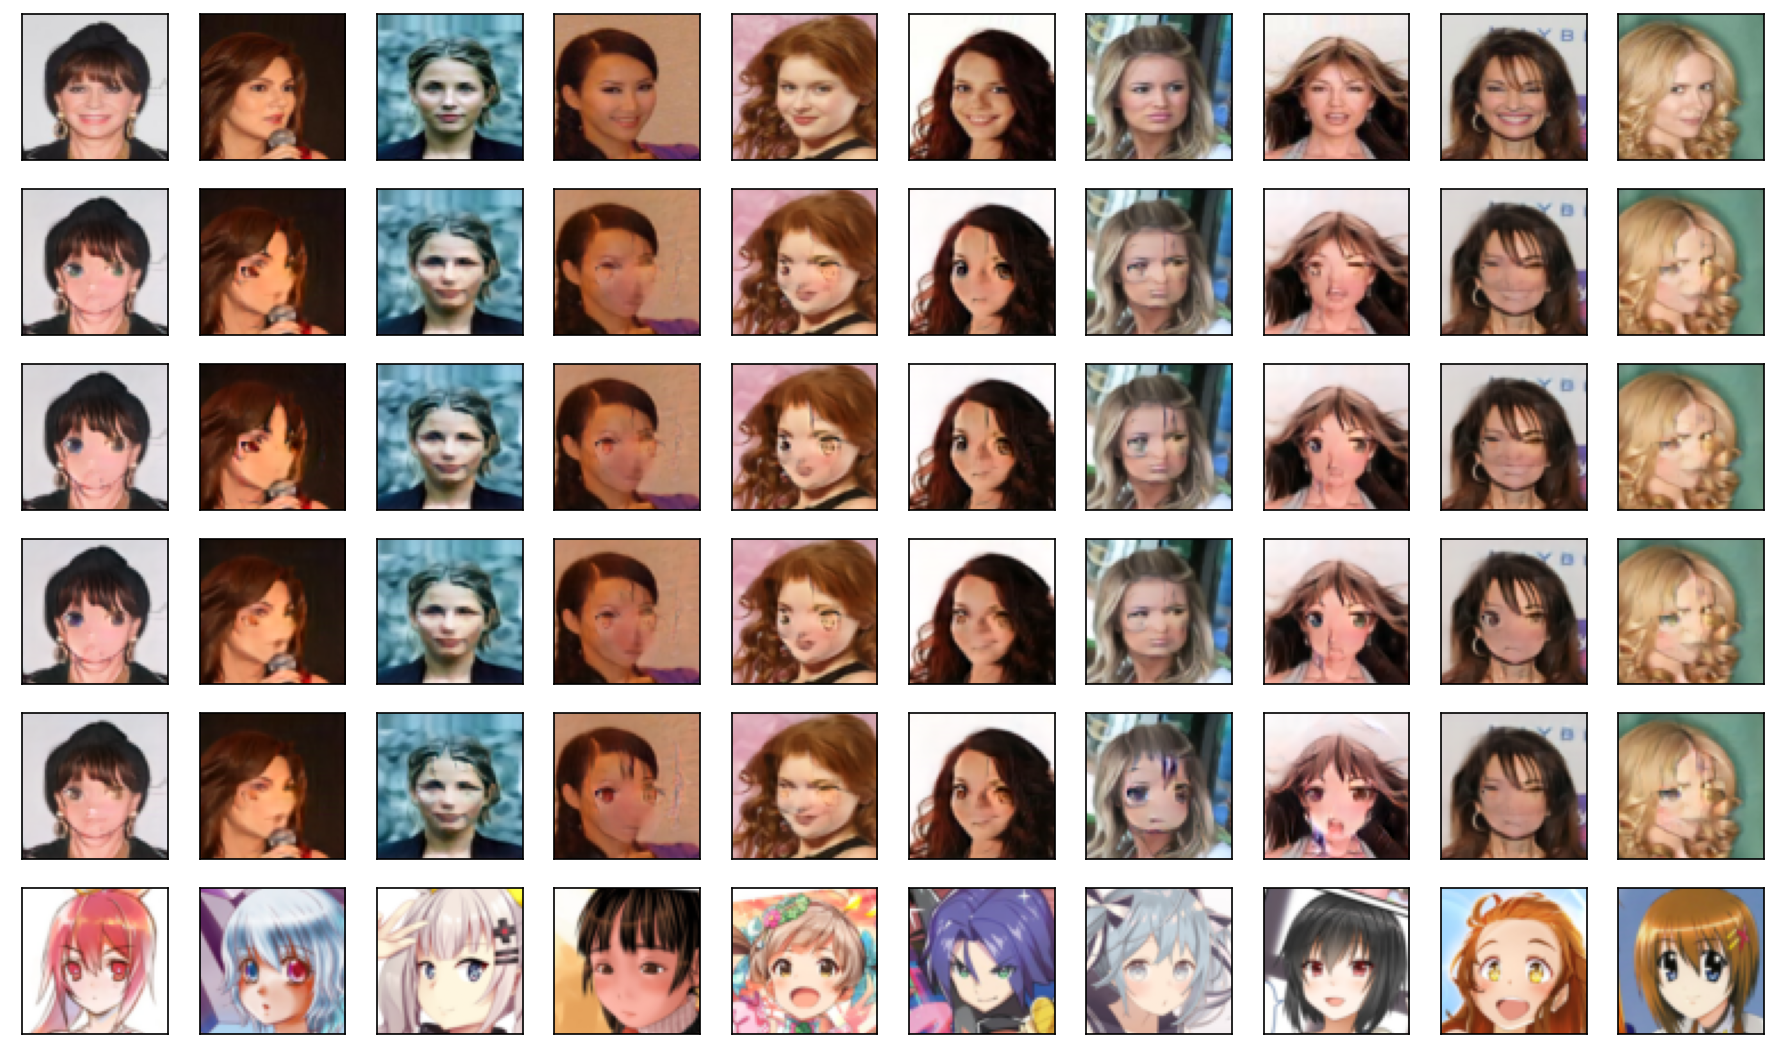

mode = test


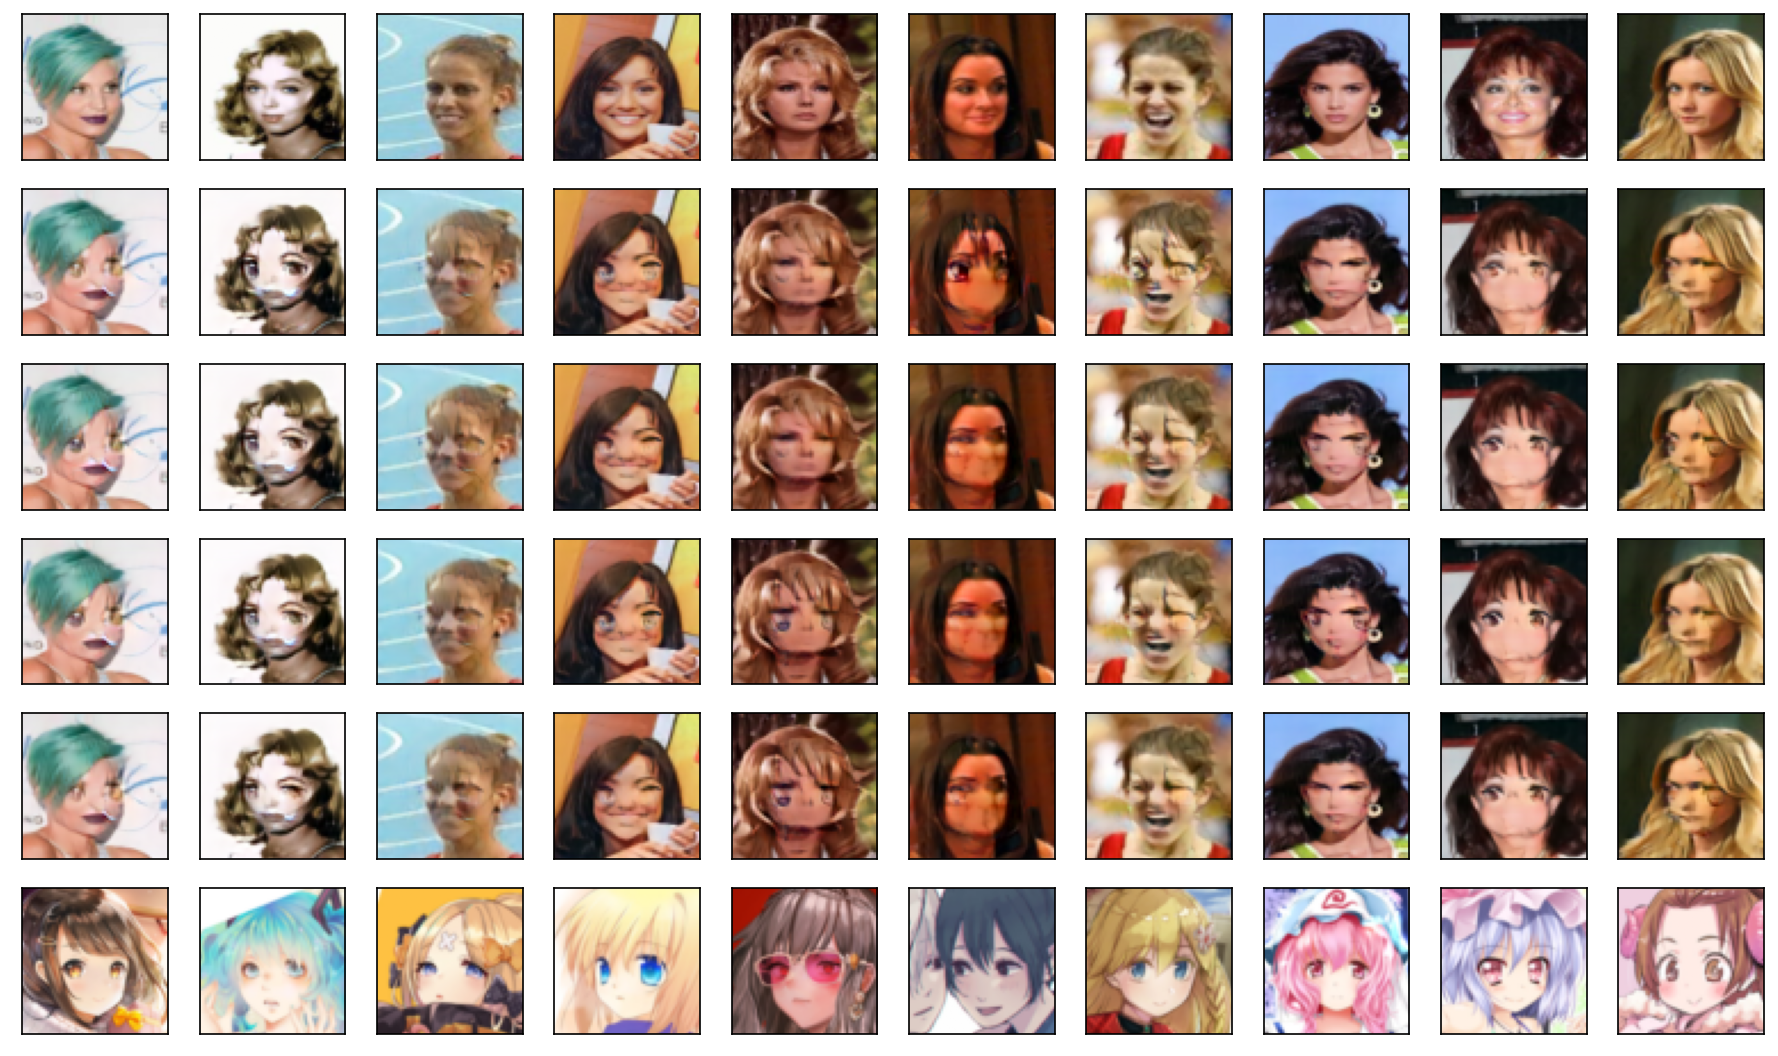

G loss = 4.3127593994140625, d loss = 1.245568871498108, lambda_id = 50.0
G loss = 5.324300289154053, d loss = 1.0654146671295166, lambda_id = 50.0
G loss = 5.575648307800293, d loss = 1.1312817335128784, lambda_id = 50.0
G loss = 5.1061482429504395, d loss = 1.2013819217681885, lambda_id = 50.0
G loss = 5.647478103637695, d loss = 1.1778452396392822, lambda_id = 50.0
G loss = 6.447301864624023, d loss = 1.1157200336456299, lambda_id = 50.0
G loss = 4.482115745544434, d loss = 1.1673872470855713, lambda_id = 50.0
G loss = 4.814448356628418, d loss = 1.1973350048065186, lambda_id = 50.0
G loss = 4.4205827713012695, d loss = 1.2731513977050781, lambda_id = 50.0
G loss = 5.928686141967773, d loss = 1.1301299333572388, lambda_id = 50.0
Elapsed time [1 day, 5:51:20], Iteration [96011/100000], D/latent_real: [0.7596] D/latent_fake: [0.3257] D/latent_reg: [0.0464] D/ref_real: [0.3564] D/ref_fake: [0.7348] D/ref_reg: [0.0390] G/latent_adv: [2.4589] G/latent_sty: [0.1963] G/latent_ds: [0.0413] 

G loss = 4.650127410888672, d loss = 1.2747801542282104, lambda_id = 50.0
G loss = 4.660172462463379, d loss = 1.2826884984970093, lambda_id = 50.0
G loss = 5.783421993255615, d loss = 1.1349900960922241, lambda_id = 50.0
G loss = 4.41534423828125, d loss = 1.1816476583480835, lambda_id = 50.0
G loss = 5.43815803527832, d loss = 1.1007120609283447, lambda_id = 50.0
Elapsed time [1 day, 5:52:36], Iteration [96081/100000], D/latent_real: [0.5775] D/latent_fake: [0.3877] D/latent_reg: [0.0444] D/ref_real: [0.4069] D/ref_fake: [0.6499] D/ref_reg: [0.0440] G/latent_adv: [2.6506] G/latent_sty: [0.1888] G/latent_ds: [0.0204] G/latent_cyc: [0.0715] G/ref_adv: [1.2713] G/ref_sty: [0.1971] G/ref_ds: [0.1053] G/ref_cyc: [0.1564] G/lambda_ds: [0.0392]
G loss = 5.437226295471191, d loss = 1.1637681722640991, lambda_id = 50.0
G loss = 5.679909706115723, d loss = 1.049722671508789, lambda_id = 50.0
G loss = 5.601572036743164, d loss = 1.0422694683074951, lambda_id = 50.0
G loss = 4.583479404449463, d

Elapsed time [1 day, 5:53:52], Iteration [96151/100000], D/latent_real: [0.5077] D/latent_fake: [0.5798] D/latent_reg: [0.0358] D/ref_real: [0.5022] D/ref_fake: [0.5959] D/ref_reg: [0.0354] G/latent_adv: [2.1608] G/latent_sty: [0.1766] G/latent_ds: [0.0345] G/latent_cyc: [0.0769] G/ref_adv: [1.0527] G/ref_sty: [0.2060] G/ref_ds: [0.0576] G/ref_cyc: [0.1480] G/lambda_ds: [0.0385]
G loss = 5.638690948486328, d loss = 1.1903733015060425, lambda_id = 50.0
G loss = 5.27589225769043, d loss = 1.1146552562713623, lambda_id = 50.0
G loss = 5.788871765136719, d loss = 1.1129539012908936, lambda_id = 50.0
G loss = 5.7473464012146, d loss = 1.0575401782989502, lambda_id = 50.0
G loss = 6.961582183837891, d loss = 0.9222021698951721, lambda_id = 50.0
G loss = 4.622871398925781, d loss = 1.1572171449661255, lambda_id = 50.0
G loss = 5.328608512878418, d loss = 1.2900882959365845, lambda_id = 50.0
G loss = 4.988622188568115, d loss = 1.1743738651275635, lambda_id = 50.0
G loss = 5.126848220825195, d

G loss = 6.471612930297852, d loss = 0.9846534729003906, lambda_id = 50.0
G loss = 5.206535339355469, d loss = 1.2622382640838623, lambda_id = 50.0
G loss = 5.496163368225098, d loss = 1.1603550910949707, lambda_id = 50.0
G loss = 6.225665092468262, d loss = 1.0758033990859985, lambda_id = 50.0
G loss = 4.766510963439941, d loss = 1.1215027570724487, lambda_id = 50.0
G loss = 4.416902542114258, d loss = 1.1723055839538574, lambda_id = 50.0
G loss = 4.956955909729004, d loss = 1.081753134727478, lambda_id = 50.0
G loss = 5.472886562347412, d loss = 1.0821561813354492, lambda_id = 50.0
G loss = 4.698060989379883, d loss = 1.1645581722259521, lambda_id = 50.0
G loss = 6.2079668045043945, d loss = 1.094241976737976, lambda_id = 50.0
Elapsed time [1 day, 5:55:19], Iteration [96231/100000], D/latent_real: [0.5019] D/latent_fake: [0.4722] D/latent_reg: [0.0568] D/ref_real: [0.4436] D/ref_fake: [0.6010] D/ref_reg: [0.0496] G/latent_adv: [2.7875] G/latent_sty: [0.2303] G/latent_ds: [0.0416] G/l

G loss = 5.781015872955322, d loss = 1.0317790508270264, lambda_id = 50.0
G loss = 5.469289779663086, d loss = 1.0723891258239746, lambda_id = 50.0
G loss = 5.444574356079102, d loss = 1.1731857061386108, lambda_id = 50.0
G loss = 6.013350009918213, d loss = 1.059950351715088, lambda_id = 50.0
G loss = 5.060175895690918, d loss = 1.1577566862106323, lambda_id = 50.0
Elapsed time [1 day, 5:56:35], Iteration [96301/100000], D/latent_real: [0.6276] D/latent_fake: [0.4936] D/latent_reg: [0.0512] D/ref_real: [0.4690] D/ref_fake: [0.6391] D/ref_reg: [0.0497] G/latent_adv: [1.9206] G/latent_sty: [0.2021] G/latent_ds: [0.0446] G/latent_cyc: [0.0790] G/ref_adv: [1.2048] G/ref_sty: [0.3133] G/ref_ds: [0.0447] G/ref_cyc: [0.1175] G/lambda_ds: [0.0370]
G loss = 6.695882797241211, d loss = 0.945491373538971, lambda_id = 50.0
G loss = 5.097472190856934, d loss = 1.1239242553710938, lambda_id = 50.0
G loss = 5.660645008087158, d loss = 1.127894639968872, lambda_id = 50.0
G loss = 5.669617652893066, d

Elapsed time [1 day, 5:57:51], Iteration [96371/100000], D/latent_real: [0.7215] D/latent_fake: [0.5441] D/latent_reg: [0.0436] D/ref_real: [0.5542] D/ref_fake: [0.6547] D/ref_reg: [0.0386] G/latent_adv: [1.5096] G/latent_sty: [0.1834] G/latent_ds: [0.0217] G/latent_cyc: [0.0756] G/ref_adv: [0.8709] G/ref_sty: [0.2138] G/ref_ds: [0.0517] G/ref_cyc: [0.1146] G/lambda_ds: [0.0363]
G loss = 5.158764839172363, d loss = 1.1904542446136475, lambda_id = 50.0
G loss = 5.055754661560059, d loss = 1.1426420211791992, lambda_id = 50.0
G loss = 4.941653251647949, d loss = 1.1975799798965454, lambda_id = 50.0
G loss = 4.605071067810059, d loss = 1.2383947372436523, lambda_id = 50.0
G loss = 4.6196112632751465, d loss = 1.2095335721969604, lambda_id = 50.0
G loss = 5.622600078582764, d loss = 1.1519993543624878, lambda_id = 50.0
G loss = 5.081048965454102, d loss = 1.175777792930603, lambda_id = 50.0
G loss = 5.014034271240234, d loss = 1.1219005584716797, lambda_id = 50.0
G loss = 4.576273918151855

G loss = 5.465914726257324, d loss = 1.1077966690063477, lambda_id = 50.0
G loss = 7.7401838302612305, d loss = 0.9014519453048706, lambda_id = 50.0
G loss = 5.383983612060547, d loss = 1.0924713611602783, lambda_id = 50.0
G loss = 6.2177276611328125, d loss = 0.9990216493606567, lambda_id = 50.0
G loss = 6.407441139221191, d loss = 1.0055797100067139, lambda_id = 50.0
G loss = 5.6622819900512695, d loss = 1.1529088020324707, lambda_id = 50.0
G loss = 5.528603553771973, d loss = 1.0706098079681396, lambda_id = 50.0
G loss = 5.42214298248291, d loss = 1.059177279472351, lambda_id = 50.0
G loss = 6.425041198730469, d loss = 1.0007715225219727, lambda_id = 50.0
G loss = 5.285676956176758, d loss = 1.1787641048431396, lambda_id = 50.0
Elapsed time [1 day, 5:59:19], Iteration [96451/100000], D/latent_real: [0.5336] D/latent_fake: [0.4856] D/latent_reg: [0.0464] D/ref_real: [0.4076] D/ref_fake: [0.7237] D/ref_reg: [0.0474] G/latent_adv: [2.4298] G/latent_sty: [0.1867] G/latent_ds: [0.0432] G

G loss = 5.618630409240723, d loss = 1.0565968751907349, lambda_id = 50.0
G loss = 4.500468730926514, d loss = 1.2805516719818115, lambda_id = 50.0
G loss = 5.717940807342529, d loss = 1.0489040613174438, lambda_id = 50.0
G loss = 5.701986312866211, d loss = 1.0728288888931274, lambda_id = 50.0
G loss = 4.681875228881836, d loss = 1.3681224584579468, lambda_id = 50.0
Elapsed time [1 day, 6:00:35], Iteration [96521/100000], D/latent_real: [0.9106] D/latent_fake: [0.3854] D/latent_reg: [0.0495] D/ref_real: [0.3997] D/ref_fake: [0.9329] D/ref_reg: [0.0355] G/latent_adv: [1.8612] G/latent_sty: [0.1941] G/latent_ds: [0.0268] G/latent_cyc: [0.0708] G/ref_adv: [1.0001] G/ref_sty: [0.2315] G/ref_ds: [0.0494] G/ref_cyc: [0.1320] G/lambda_ds: [0.0348]
G loss = 5.159812927246094, d loss = 1.1173346042633057, lambda_id = 50.0
G loss = 5.63739013671875, d loss = 1.2100732326507568, lambda_id = 50.0
G loss = 5.7717976570129395, d loss = 1.0699466466903687, lambda_id = 50.0
G loss = 5.422895908355713

Elapsed time [1 day, 6:01:51], Iteration [96591/100000], D/latent_real: [0.6649] D/latent_fake: [0.3529] D/latent_reg: [0.0431] D/ref_real: [0.3938] D/ref_fake: [0.7827] D/ref_reg: [0.0412] G/latent_adv: [2.1725] G/latent_sty: [0.1612] G/latent_ds: [0.0306] G/latent_cyc: [0.0713] G/ref_adv: [1.1077] G/ref_sty: [0.1549] G/ref_ds: [0.0666] G/ref_cyc: [0.1110] G/lambda_ds: [0.0341]
G loss = 5.133847713470459, d loss = 1.1585594415664673, lambda_id = 50.0
G loss = 4.767390251159668, d loss = 1.1513330936431885, lambda_id = 50.0
G loss = 4.662642478942871, d loss = 1.14847731590271, lambda_id = 50.0
G loss = 5.167600631713867, d loss = 1.0069409608840942, lambda_id = 50.0
G loss = 4.422510147094727, d loss = 1.2519948482513428, lambda_id = 50.0
G loss = 4.623504161834717, d loss = 1.158953309059143, lambda_id = 50.0
G loss = 5.492986679077148, d loss = 1.1374821662902832, lambda_id = 50.0
G loss = 5.501346111297607, d loss = 1.1212158203125, lambda_id = 50.0
G loss = 5.003437042236328, d lo

G loss = 4.660000801086426, d loss = 1.2190872430801392, lambda_id = 50.0
G loss = 5.927492618560791, d loss = 1.1144424676895142, lambda_id = 50.0
G loss = 6.289373397827148, d loss = 1.1417962312698364, lambda_id = 50.0
G loss = 4.629949569702148, d loss = 1.2562083005905151, lambda_id = 50.0
G loss = 5.166354179382324, d loss = 1.177990436553955, lambda_id = 50.0
G loss = 5.598417282104492, d loss = 1.1686210632324219, lambda_id = 50.0
G loss = 5.363559722900391, d loss = 1.1937286853790283, lambda_id = 50.0
G loss = 5.317018985748291, d loss = 1.149845838546753, lambda_id = 50.0
G loss = 5.6820878982543945, d loss = 1.1648578643798828, lambda_id = 50.0
G loss = 6.599328994750977, d loss = 1.1208730936050415, lambda_id = 50.0
Elapsed time [1 day, 6:03:18], Iteration [96671/100000], D/latent_real: [0.5544] D/latent_fake: [0.4294] D/latent_reg: [0.0429] D/ref_real: [0.4168] D/ref_fake: [0.6645] D/ref_reg: [0.0396] G/latent_adv: [2.7974] G/latent_sty: [0.1683] G/latent_ds: [0.0491] G/l

G loss = 5.817289352416992, d loss = 0.9591584205627441, lambda_id = 50.0
G loss = 5.225431442260742, d loss = 1.1467431783676147, lambda_id = 50.0
G loss = 6.147795677185059, d loss = 1.069373607635498, lambda_id = 50.0
G loss = 5.831953048706055, d loss = 1.137783408164978, lambda_id = 50.0
G loss = 5.987900733947754, d loss = 1.1438367366790771, lambda_id = 50.0
Elapsed time [1 day, 6:04:35], Iteration [96741/100000], D/latent_real: [0.5856] D/latent_fake: [0.3362] D/latent_reg: [0.0533] D/ref_real: [0.3220] D/ref_fake: [0.7759] D/ref_reg: [0.0460] G/latent_adv: [2.7729] G/latent_sty: [0.1876] G/latent_ds: [0.0394] G/latent_cyc: [0.0851] G/ref_adv: [1.6249] G/ref_sty: [0.2436] G/ref_ds: [0.0597] G/ref_cyc: [0.1919] G/lambda_ds: [0.0326]
G loss = 5.385565280914307, d loss = 1.1343164443969727, lambda_id = 50.0
G loss = 5.485856056213379, d loss = 1.153817892074585, lambda_id = 50.0
G loss = 5.105415344238281, d loss = 1.2350702285766602, lambda_id = 50.0
G loss = 7.026684761047363, d

Elapsed time [1 day, 6:05:51], Iteration [96811/100000], D/latent_real: [0.6302] D/latent_fake: [0.4824] D/latent_reg: [0.0460] D/ref_real: [0.4388] D/ref_fake: [0.7035] D/ref_reg: [0.0389] G/latent_adv: [1.8379] G/latent_sty: [0.2560] G/latent_ds: [0.0484] G/latent_cyc: [0.0832] G/ref_adv: [1.1903] G/ref_sty: [0.1821] G/ref_ds: [0.0970] G/ref_cyc: [0.1271] G/lambda_ds: [0.0319]
G loss = 5.1826934814453125, d loss = 1.145275592803955, lambda_id = 50.0
G loss = 5.815341472625732, d loss = 1.147709608078003, lambda_id = 50.0
G loss = 4.978283405303955, d loss = 1.0654761791229248, lambda_id = 50.0
G loss = 6.596360206604004, d loss = 1.04840886592865, lambda_id = 50.0
G loss = 5.899832248687744, d loss = 0.9548901319503784, lambda_id = 50.0
G loss = 4.397152900695801, d loss = 1.2010066509246826, lambda_id = 50.0
G loss = 5.379366874694824, d loss = 1.0785456895828247, lambda_id = 50.0
G loss = 6.112512588500977, d loss = 1.0170832872390747, lambda_id = 50.0
G loss = 5.160466194152832, d

G loss = 5.870294570922852, d loss = 1.0958349704742432, lambda_id = 50.0
G loss = 6.290915489196777, d loss = 1.1977064609527588, lambda_id = 50.0
G loss = 6.262594223022461, d loss = 1.1135481595993042, lambda_id = 50.0
G loss = 5.934179782867432, d loss = 1.1836930513381958, lambda_id = 50.0
G loss = 5.89947509765625, d loss = 1.1537717580795288, lambda_id = 50.0
G loss = 4.367637634277344, d loss = 1.2268606424331665, lambda_id = 50.0
G loss = 6.4163432121276855, d loss = 1.10428786277771, lambda_id = 50.0
G loss = 5.376775741577148, d loss = 1.1443992853164673, lambda_id = 50.0
G loss = 6.230353832244873, d loss = 1.0952712297439575, lambda_id = 50.0
G loss = 4.550353050231934, d loss = 1.2162100076675415, lambda_id = 50.0
Elapsed time [1 day, 6:07:18], Iteration [96891/100000], D/latent_real: [0.7550] D/latent_fake: [0.6612] D/latent_reg: [0.0571] D/ref_real: [0.5590] D/ref_fake: [0.6181] D/ref_reg: [0.0392] G/latent_adv: [1.5682] G/latent_sty: [0.1721] G/latent_ds: [0.0254] G/la

G loss = 4.231301307678223, d loss = 1.3299031257629395, lambda_id = 50.0
G loss = 5.14112663269043, d loss = 1.2158119678497314, lambda_id = 50.0
G loss = 5.223421096801758, d loss = 1.2032915353775024, lambda_id = 50.0
G loss = 5.2804107666015625, d loss = 1.0226130485534668, lambda_id = 50.0
G loss = 5.261965751647949, d loss = 1.1007531881332397, lambda_id = 50.0
Elapsed time [1 day, 6:08:34], Iteration [96961/100000], D/latent_real: [0.4908] D/latent_fake: [0.4711] D/latent_reg: [0.0393] D/ref_real: [0.4148] D/ref_fake: [0.6460] D/ref_reg: [0.0400] G/latent_adv: [2.4913] G/latent_sty: [0.1848] G/latent_ds: [0.0231] G/latent_cyc: [0.0689] G/ref_adv: [1.0707] G/ref_sty: [0.2131] G/ref_ds: [0.0897] G/ref_cyc: [0.1571] G/lambda_ds: [0.0304]
G loss = 5.949521064758301, d loss = 1.17616868019104, lambda_id = 50.0
G loss = 5.756696701049805, d loss = 1.1538701057434082, lambda_id = 50.0
G loss = 4.693320274353027, d loss = 1.2498365640640259, lambda_id = 50.0
G loss = 5.924506664276123, 

Elapsed time [1 day, 6:09:50], Iteration [97031/100000], D/latent_real: [0.6685] D/latent_fake: [0.4290] D/latent_reg: [0.0498] D/ref_real: [0.4222] D/ref_fake: [0.7360] D/ref_reg: [0.0475] G/latent_adv: [2.1393] G/latent_sty: [0.2126] G/latent_ds: [0.0233] G/latent_cyc: [0.0717] G/ref_adv: [0.9534] G/ref_sty: [0.1904] G/ref_ds: [0.0487] G/ref_cyc: [0.1420] G/lambda_ds: [0.0297]
G loss = 5.028977870941162, d loss = 1.1706833839416504, lambda_id = 50.0
G loss = 6.9401469230651855, d loss = 1.021736741065979, lambda_id = 50.0
G loss = 5.484585762023926, d loss = 1.1332523822784424, lambda_id = 50.0
G loss = 5.536376953125, d loss = 1.180837631225586, lambda_id = 50.0
G loss = 6.084249496459961, d loss = 1.1274727582931519, lambda_id = 50.0
G loss = 4.528529644012451, d loss = 1.1710631847381592, lambda_id = 50.0
G loss = 5.963386535644531, d loss = 1.1077430248260498, lambda_id = 50.0
G loss = 6.812339782714844, d loss = 1.0383059978485107, lambda_id = 50.0
G loss = 5.128737449645996, d 

G loss = 5.559247970581055, d loss = 1.178941249847412, lambda_id = 50.0
G loss = 5.511970520019531, d loss = 1.1008340120315552, lambda_id = 50.0
G loss = 4.556944370269775, d loss = 1.2657139301300049, lambda_id = 50.0
G loss = 4.527353286743164, d loss = 1.1776736974716187, lambda_id = 50.0
G loss = 5.209298133850098, d loss = 1.1539008617401123, lambda_id = 50.0
G loss = 6.220937728881836, d loss = 1.0325273275375366, lambda_id = 50.0
G loss = 5.834712982177734, d loss = 1.1218503713607788, lambda_id = 50.0
G loss = 6.55234432220459, d loss = 1.042008876800537, lambda_id = 50.0
G loss = 4.916460037231445, d loss = 1.1960365772247314, lambda_id = 50.0
G loss = 4.385079383850098, d loss = 1.2447166442871094, lambda_id = 50.0
Elapsed time [1 day, 6:11:17], Iteration [97111/100000], D/latent_real: [0.6856] D/latent_fake: [0.5384] D/latent_reg: [0.0500] D/ref_real: [0.4932] D/ref_fake: [0.7072] D/ref_reg: [0.0443] G/latent_adv: [1.5992] G/latent_sty: [0.1554] G/latent_ds: [0.0336] G/lat

G loss = 5.821727275848389, d loss = 1.0959888696670532, lambda_id = 50.0
G loss = 5.877391815185547, d loss = 1.1810119152069092, lambda_id = 50.0
G loss = 8.209883689880371, d loss = 1.0001749992370605, lambda_id = 50.0
G loss = 5.764516830444336, d loss = 1.2141072750091553, lambda_id = 50.0
G loss = 6.732701301574707, d loss = 1.1075361967086792, lambda_id = 50.0
Elapsed time [1 day, 6:12:34], Iteration [97181/100000], D/latent_real: [0.6979] D/latent_fake: [0.2512] D/latent_reg: [0.0442] D/ref_real: [0.3477] D/ref_fake: [0.7184] D/ref_reg: [0.0415] G/latent_adv: [2.7007] G/latent_sty: [0.2020] G/latent_ds: [0.0445] G/latent_cyc: [0.0913] G/ref_adv: [1.5965] G/ref_sty: [0.2611] G/ref_ds: [0.0882] G/ref_cyc: [0.1879] G/lambda_ds: [0.0282]
G loss = 5.299679756164551, d loss = 1.0964709520339966, lambda_id = 50.0
G loss = 4.710156440734863, d loss = 1.2275457382202148, lambda_id = 50.0
G loss = 5.233015060424805, d loss = 1.183109998703003, lambda_id = 50.0
G loss = 5.4959635734558105

Elapsed time [1 day, 6:13:50], Iteration [97251/100000], D/latent_real: [0.6241] D/latent_fake: [0.2204] D/latent_reg: [0.0390] D/ref_real: [0.3241] D/ref_fake: [0.6090] D/ref_reg: [0.0405] G/latent_adv: [3.2241] G/latent_sty: [0.2113] G/latent_ds: [0.0544] G/latent_cyc: [0.0753] G/ref_adv: [1.6764] G/ref_sty: [0.2083] G/ref_ds: [0.1524] G/ref_cyc: [0.1609] G/lambda_ds: [0.0275]
G loss = 6.638853073120117, d loss = 1.1190979480743408, lambda_id = 50.0
G loss = 5.935643196105957, d loss = 1.0930088758468628, lambda_id = 50.0
G loss = 5.415236949920654, d loss = 1.2131539583206177, lambda_id = 50.0
G loss = 5.5521240234375, d loss = 1.1077038049697876, lambda_id = 50.0
G loss = 5.208489418029785, d loss = 1.1878730058670044, lambda_id = 50.0
G loss = 5.889682769775391, d loss = 1.052825689315796, lambda_id = 50.0
G loss = 4.888856887817383, d loss = 1.2079485654830933, lambda_id = 50.0
G loss = 5.5290985107421875, d loss = 1.167862057685852, lambda_id = 50.0
G loss = 4.534452438354492, d

G loss = 4.985089302062988, d loss = 1.255664587020874, lambda_id = 50.0
G loss = 5.0794267654418945, d loss = 1.142614483833313, lambda_id = 50.0
G loss = 4.871177673339844, d loss = 1.1811631917953491, lambda_id = 50.0
G loss = 5.132661819458008, d loss = 1.2137258052825928, lambda_id = 50.0
G loss = 5.271701812744141, d loss = 1.189927101135254, lambda_id = 50.0
G loss = 4.678243637084961, d loss = 1.1681650876998901, lambda_id = 50.0
G loss = 5.6556782722473145, d loss = 1.144118309020996, lambda_id = 50.0
G loss = 4.5249223709106445, d loss = 1.2862348556518555, lambda_id = 50.0
G loss = 4.94058895111084, d loss = 1.216646432876587, lambda_id = 50.0
G loss = 5.286060810089111, d loss = 1.1532361507415771, lambda_id = 50.0
Elapsed time [1 day, 6:15:17], Iteration [97331/100000], D/latent_real: [0.6663] D/latent_fake: [0.4422] D/latent_reg: [0.0400] D/ref_real: [0.4399] D/ref_fake: [0.6756] D/ref_reg: [0.0378] G/latent_adv: [2.2639] G/latent_sty: [0.2690] G/latent_ds: [0.0369] G/lat

G loss = 4.743990898132324, d loss = 1.3670822381973267, lambda_id = 50.0
G loss = 5.789938926696777, d loss = 1.1965903043746948, lambda_id = 50.0
G loss = 5.23302698135376, d loss = 1.141453504562378, lambda_id = 50.0
G loss = 5.640020370483398, d loss = 1.193784236907959, lambda_id = 50.0
G loss = 5.593904495239258, d loss = 1.137737512588501, lambda_id = 50.0
Elapsed time [1 day, 6:16:33], Iteration [97401/100000], D/latent_real: [0.7358] D/latent_fake: [0.2938] D/latent_reg: [0.0434] D/ref_real: [0.3714] D/ref_fake: [0.7282] D/ref_reg: [0.0382] G/latent_adv: [2.4825] G/latent_sty: [0.1676] G/latent_ds: [0.0279] G/latent_cyc: [0.0813] G/ref_adv: [1.0826] G/ref_sty: [0.1631] G/ref_ds: [0.0790] G/ref_cyc: [0.1464] G/lambda_ds: [0.0260]
G loss = 5.845815658569336, d loss = 1.1171456575393677, lambda_id = 50.0
G loss = 4.147739410400391, d loss = 1.3397077322006226, lambda_id = 50.0
G loss = 5.360224723815918, d loss = 1.1972817182540894, lambda_id = 50.0
G loss = 5.0956830978393555, d

Elapsed time [1 day, 6:17:49], Iteration [97471/100000], D/latent_real: [0.6583] D/latent_fake: [0.4179] D/latent_reg: [0.0412] D/ref_real: [0.4722] D/ref_fake: [0.6769] D/ref_reg: [0.0424] G/latent_adv: [2.1368] G/latent_sty: [0.1710] G/latent_ds: [0.0258] G/latent_cyc: [0.0810] G/ref_adv: [1.0715] G/ref_sty: [0.1765] G/ref_ds: [0.0550] G/ref_cyc: [0.1229] G/lambda_ds: [0.0253]
G loss = 5.740436553955078, d loss = 1.2018694877624512, lambda_id = 50.0
G loss = 5.392956733703613, d loss = 1.1563045978546143, lambda_id = 50.0
G loss = 4.6102447509765625, d loss = 1.221995234489441, lambda_id = 50.0
G loss = 5.61809778213501, d loss = 1.139965534210205, lambda_id = 50.0
G loss = 5.571053504943848, d loss = 1.110499620437622, lambda_id = 50.0
G loss = 9.247529983520508, d loss = 0.9999402761459351, lambda_id = 50.0
G loss = 7.156572341918945, d loss = 1.0967576503753662, lambda_id = 50.0
G loss = 6.986024856567383, d loss = 1.000882625579834, lambda_id = 50.0
G loss = 5.830331802368164, d 

G loss = 6.795046806335449, d loss = 1.0167902708053589, lambda_id = 50.0
G loss = 5.2051897048950195, d loss = 1.17205810546875, lambda_id = 50.0
G loss = 6.0475945472717285, d loss = 1.1003671884536743, lambda_id = 50.0
G loss = 4.011621475219727, d loss = 1.3448721170425415, lambda_id = 50.0
G loss = 5.094117164611816, d loss = 1.1596165895462036, lambda_id = 50.0
G loss = 6.546936511993408, d loss = 0.9680539965629578, lambda_id = 50.0
G loss = 6.157744407653809, d loss = 1.1565396785736084, lambda_id = 50.0
G loss = 4.146514415740967, d loss = 1.289658784866333, lambda_id = 50.0
G loss = 6.359620571136475, d loss = 1.0678303241729736, lambda_id = 50.0
G loss = 6.363426685333252, d loss = 1.0919312238693237, lambda_id = 50.0
Elapsed time [1 day, 6:19:16], Iteration [97551/100000], D/latent_real: [0.6249] D/latent_fake: [0.2732] D/latent_reg: [0.0462] D/ref_real: [0.3196] D/ref_fake: [0.7310] D/ref_reg: [0.0414] G/latent_adv: [3.1443] G/latent_sty: [0.1685] G/latent_ds: [0.0293] G/l

G loss = 5.797964096069336, d loss = 1.0767524242401123, lambda_id = 50.0
G loss = 4.611327171325684, d loss = 1.2889776229858398, lambda_id = 50.0
G loss = 5.046503067016602, d loss = 1.189100742340088, lambda_id = 50.0
G loss = 4.908130645751953, d loss = 1.153835415840149, lambda_id = 50.0
G loss = 5.0457444190979, d loss = 1.2827173471450806, lambda_id = 50.0
Elapsed time [1 day, 6:20:32], Iteration [97621/100000], D/latent_real: [0.6705] D/latent_fake: [0.5208] D/latent_reg: [0.0475] D/ref_real: [0.4767] D/ref_fake: [0.7624] D/ref_reg: [0.0436] G/latent_adv: [1.7343] G/latent_sty: [0.1682] G/latent_ds: [0.0472] G/latent_cyc: [0.0725] G/ref_adv: [0.9879] G/ref_sty: [0.2735] G/ref_ds: [0.0732] G/ref_cyc: [0.1114] G/lambda_ds: [0.0238]
G loss = 5.082003593444824, d loss = 1.200036644935608, lambda_id = 50.0
G loss = 6.158280849456787, d loss = 0.9912508726119995, lambda_id = 50.0
G loss = 4.728799819946289, d loss = 1.269446611404419, lambda_id = 50.0
G loss = 4.961203575134277, d lo

Elapsed time [1 day, 6:21:48], Iteration [97691/100000], D/latent_real: [0.6455] D/latent_fake: [0.2771] D/latent_reg: [0.0398] D/ref_real: [0.3199] D/ref_fake: [0.7372] D/ref_reg: [0.0373] G/latent_adv: [3.2268] G/latent_sty: [0.1892] G/latent_ds: [0.0237] G/latent_cyc: [0.0723] G/ref_adv: [1.1911] G/ref_sty: [0.1969] G/ref_ds: [0.0460] G/ref_cyc: [0.1808] G/lambda_ds: [0.0231]
G loss = 5.532102584838867, d loss = 1.135767936706543, lambda_id = 50.0
G loss = 5.085409164428711, d loss = 1.188063144683838, lambda_id = 50.0
G loss = 5.154549598693848, d loss = 1.1854736804962158, lambda_id = 50.0
G loss = 5.840883255004883, d loss = 1.0532110929489136, lambda_id = 50.0
G loss = 5.702057838439941, d loss = 1.1861985921859741, lambda_id = 50.0
G loss = 4.869712829589844, d loss = 1.2895076274871826, lambda_id = 50.0
G loss = 6.124937057495117, d loss = 0.9765403270721436, lambda_id = 50.0
G loss = 4.373086452484131, d loss = 1.2301371097564697, lambda_id = 50.0
G loss = 5.228708267211914, 

G loss = 6.6596527099609375, d loss = 1.0670932531356812, lambda_id = 50.0
G loss = 4.624107837677002, d loss = 1.1979093551635742, lambda_id = 50.0
G loss = 4.186734199523926, d loss = 1.2589932680130005, lambda_id = 50.0
G loss = 4.804617881774902, d loss = 1.1611616611480713, lambda_id = 50.0
G loss = 4.777065277099609, d loss = 1.1656137704849243, lambda_id = 50.0
G loss = 5.659548759460449, d loss = 1.0506541728973389, lambda_id = 50.0
G loss = 5.517276763916016, d loss = 1.1584184169769287, lambda_id = 50.0
G loss = 5.985797882080078, d loss = 1.1217401027679443, lambda_id = 50.0
G loss = 4.2245192527771, d loss = 1.2847059965133667, lambda_id = 50.0
G loss = 5.768632888793945, d loss = 1.1860997676849365, lambda_id = 50.0
Elapsed time [1 day, 6:23:15], Iteration [97771/100000], D/latent_real: [0.7130] D/latent_fake: [0.2963] D/latent_reg: [0.0409] D/ref_real: [0.3498] D/ref_fake: [0.7969] D/ref_reg: [0.0393] G/latent_adv: [2.4693] G/latent_sty: [0.1846] G/latent_ds: [0.0289] G/l

G loss = 5.063995361328125, d loss = 1.232901930809021, lambda_id = 50.0
G loss = 6.087060451507568, d loss = 1.14913809299469, lambda_id = 50.0
G loss = 5.899191856384277, d loss = 1.0764248371124268, lambda_id = 50.0
G loss = 6.6361985206604, d loss = 1.0975699424743652, lambda_id = 50.0
G loss = 5.847980976104736, d loss = 1.228980302810669, lambda_id = 50.0
Elapsed time [1 day, 6:24:31], Iteration [97841/100000], D/latent_real: [0.6102] D/latent_fake: [0.4240] D/latent_reg: [0.0472] D/ref_real: [0.4794] D/ref_fake: [0.7008] D/ref_reg: [0.0488] G/latent_adv: [2.5710] G/latent_sty: [0.2031] G/latent_ds: [0.0442] G/latent_cyc: [0.0794] G/ref_adv: [0.9107] G/ref_sty: [0.2409] G/ref_ds: [0.0693] G/ref_cyc: [0.1566] G/lambda_ds: [0.0216]
G loss = 5.716061592102051, d loss = 1.189111590385437, lambda_id = 50.0
G loss = 6.079966068267822, d loss = 1.1436443328857422, lambda_id = 50.0
G loss = 5.337933540344238, d loss = 1.082944631576538, lambda_id = 50.0
G loss = 6.258238315582275, d loss

Elapsed time [1 day, 6:25:47], Iteration [97911/100000], D/latent_real: [0.6090] D/latent_fake: [0.4153] D/latent_reg: [0.0525] D/ref_real: [0.3448] D/ref_fake: [0.7341] D/ref_reg: [0.0445] G/latent_adv: [2.7142] G/latent_sty: [0.1849] G/latent_ds: [0.0365] G/latent_cyc: [0.0862] G/ref_adv: [1.1930] G/ref_sty: [0.2071] G/ref_ds: [0.0902] G/ref_cyc: [0.1699] G/lambda_ds: [0.0209]
G loss = 6.266186237335205, d loss = 1.060233235359192, lambda_id = 50.0
G loss = 5.633377552032471, d loss = 1.1412642002105713, lambda_id = 50.0
G loss = 5.7784423828125, d loss = 1.1661157608032227, lambda_id = 50.0
G loss = 5.513526916503906, d loss = 1.1803237199783325, lambda_id = 50.0
G loss = 6.163684844970703, d loss = 1.0678149461746216, lambda_id = 50.0
G loss = 4.82340145111084, d loss = 1.2690404653549194, lambda_id = 50.0
G loss = 5.721797943115234, d loss = 1.1104224920272827, lambda_id = 50.0
G loss = 4.793031215667725, d loss = 1.0797690153121948, lambda_id = 50.0
G loss = 6.790563583374023, d 

G loss = 4.406125545501709, d loss = 1.202466368675232, lambda_id = 50.0
G loss = 5.094841480255127, d loss = 1.2295317649841309, lambda_id = 50.0
G loss = 5.880035877227783, d loss = 1.1404736042022705, lambda_id = 50.0
G loss = 6.336718559265137, d loss = 1.104570984840393, lambda_id = 50.0
G loss = 4.727655410766602, d loss = 1.1594562530517578, lambda_id = 50.0
G loss = 5.41018009185791, d loss = 1.1172372102737427, lambda_id = 50.0
G loss = 5.1841535568237305, d loss = 1.1773180961608887, lambda_id = 50.0
G loss = 5.282927513122559, d loss = 1.108523964881897, lambda_id = 50.0
G loss = 5.420561790466309, d loss = 1.1239650249481201, lambda_id = 50.0
G loss = 6.565742492675781, d loss = 1.031656265258789, lambda_id = 50.0
Elapsed time [1 day, 6:27:14], Iteration [97991/100000], D/latent_real: [0.5353] D/latent_fake: [0.3509] D/latent_reg: [0.0498] D/ref_real: [0.3397] D/ref_fake: [0.6434] D/ref_reg: [0.0486] G/latent_adv: [3.2081] G/latent_sty: [0.2441] G/latent_ds: [0.0272] G/late

G loss = 5.024345397949219, d loss = 1.1899209022521973, lambda_id = 50.0
G loss = 5.643431663513184, d loss = 1.1856333017349243, lambda_id = 50.0
G loss = 5.852949142456055, d loss = 1.086447834968567, lambda_id = 50.0
G loss = 4.568240165710449, d loss = 1.2611547708511353, lambda_id = 50.0
G loss = 6.192883491516113, d loss = 1.0538526773452759, lambda_id = 50.0
Elapsed time [1 day, 6:28:30], Iteration [98061/100000], D/latent_real: [0.7321] D/latent_fake: [0.2505] D/latent_reg: [0.0456] D/ref_real: [0.3315] D/ref_fake: [0.6774] D/ref_reg: [0.0449] G/latent_adv: [3.0304] G/latent_sty: [0.1936] G/latent_ds: [0.0283] G/latent_cyc: [0.0746] G/ref_adv: [1.5244] G/ref_sty: [0.1967] G/ref_ds: [0.0791] G/ref_cyc: [0.1407] G/lambda_ds: [0.0194]
G loss = 4.042001247406006, d loss = 1.2088383436203003, lambda_id = 50.0
G loss = 5.548712253570557, d loss = 1.241799235343933, lambda_id = 50.0
G loss = 5.183487892150879, d loss = 1.1432088613510132, lambda_id = 50.0
G loss = 6.394521713256836, 

Elapsed time [1 day, 6:29:46], Iteration [98131/100000], D/latent_real: [0.6140] D/latent_fake: [0.4160] D/latent_reg: [0.0457] D/ref_real: [0.4266] D/ref_fake: [0.7146] D/ref_reg: [0.0465] G/latent_adv: [2.3948] G/latent_sty: [0.1902] G/latent_ds: [0.0203] G/latent_cyc: [0.0699] G/ref_adv: [1.0611] G/ref_sty: [0.1610] G/ref_ds: [0.0644] G/ref_cyc: [0.1180] G/lambda_ds: [0.0187]
G loss = 6.009585380554199, d loss = 1.1737101078033447, lambda_id = 50.0
G loss = 4.428894996643066, d loss = 1.2405749559402466, lambda_id = 50.0
G loss = 5.178836822509766, d loss = 1.1495599746704102, lambda_id = 50.0
G loss = 4.514236927032471, d loss = 1.2528175115585327, lambda_id = 50.0
G loss = 6.381535053253174, d loss = 1.0833417177200317, lambda_id = 50.0
G loss = 4.999286651611328, d loss = 1.183959722518921, lambda_id = 50.0
G loss = 5.326961517333984, d loss = 1.2139544486999512, lambda_id = 50.0
G loss = 5.046206474304199, d loss = 1.1796985864639282, lambda_id = 50.0
G loss = 5.015522003173828,

G loss = 4.989310264587402, d loss = 1.2910822629928589, lambda_id = 50.0
G loss = 5.8878278732299805, d loss = 1.1885428428649902, lambda_id = 50.0
G loss = 5.404150009155273, d loss = 1.310160756111145, lambda_id = 50.0
G loss = 6.067214012145996, d loss = 1.2231234312057495, lambda_id = 50.0
G loss = 6.645506858825684, d loss = 1.1919163465499878, lambda_id = 50.0
G loss = 5.568996429443359, d loss = 1.0908715724945068, lambda_id = 50.0
G loss = 5.115456581115723, d loss = 1.1308445930480957, lambda_id = 50.0
G loss = 5.239994525909424, d loss = 1.1788384914398193, lambda_id = 50.0
G loss = 5.964692115783691, d loss = 1.1972250938415527, lambda_id = 50.0
G loss = 6.504826545715332, d loss = 1.0264804363250732, lambda_id = 50.0
Elapsed time [1 day, 6:31:13], Iteration [98211/100000], D/latent_real: [0.6619] D/latent_fake: [0.1777] D/latent_reg: [0.0402] D/ref_real: [0.2875] D/ref_fake: [0.7016] D/ref_reg: [0.0374] G/latent_adv: [3.5077] G/latent_sty: [0.1591] G/latent_ds: [0.0336] G/

G loss = 5.3298187255859375, d loss = 1.1236923933029175, lambda_id = 50.0
G loss = 5.898807525634766, d loss = 0.9984610676765442, lambda_id = 50.0
G loss = 5.303727149963379, d loss = 1.2212241888046265, lambda_id = 50.0
G loss = 4.809418678283691, d loss = 1.159703254699707, lambda_id = 50.0
G loss = 5.0704874992370605, d loss = 1.1021524667739868, lambda_id = 50.0
Elapsed time [1 day, 6:32:29], Iteration [98281/100000], D/latent_real: [0.7032] D/latent_fake: [0.3043] D/latent_reg: [0.0536] D/ref_real: [0.3781] D/ref_fake: [0.6799] D/ref_reg: [0.0441] G/latent_adv: [2.4632] G/latent_sty: [0.2007] G/latent_ds: [0.0240] G/latent_cyc: [0.0716] G/ref_adv: [1.2311] G/ref_sty: [0.2810] G/ref_ds: [0.0853] G/ref_cyc: [0.1691] G/lambda_ds: [0.0172]
G loss = 6.4427008628845215, d loss = 1.1552109718322754, lambda_id = 50.0
G loss = 5.000714302062988, d loss = 1.2034826278686523, lambda_id = 50.0
G loss = 4.913758277893066, d loss = 1.209428071975708, lambda_id = 50.0
G loss = 6.01794052124023

Elapsed time [1 day, 6:33:45], Iteration [98351/100000], D/latent_real: [0.6733] D/latent_fake: [0.2605] D/latent_reg: [0.0597] D/ref_real: [0.2647] D/ref_fake: [0.7131] D/ref_reg: [0.0453] G/latent_adv: [3.0671] G/latent_sty: [0.1588] G/latent_ds: [0.0299] G/latent_cyc: [0.0777] G/ref_adv: [1.4331] G/ref_sty: [0.2372] G/ref_ds: [0.0956] G/ref_cyc: [0.1700] G/lambda_ds: [0.0165]
G loss = 5.952607154846191, d loss = 1.0697665214538574, lambda_id = 50.0
G loss = 5.638195037841797, d loss = 1.1794941425323486, lambda_id = 50.0
G loss = 5.233447074890137, d loss = 1.3588463068008423, lambda_id = 50.0
G loss = 6.247837066650391, d loss = 1.1278934478759766, lambda_id = 50.0
G loss = 4.758434295654297, d loss = 1.2317521572113037, lambda_id = 50.0
G loss = 4.7528886795043945, d loss = 1.1285853385925293, lambda_id = 50.0
G loss = 5.562189102172852, d loss = 1.1200687885284424, lambda_id = 50.0
G loss = 5.861005783081055, d loss = 1.1328935623168945, lambda_id = 50.0
G loss = 4.97560071945190

G loss = 4.62339973449707, d loss = 1.262912631034851, lambda_id = 50.0
G loss = 5.266257286071777, d loss = 1.1553484201431274, lambda_id = 50.0
G loss = 5.261390686035156, d loss = 1.1585084199905396, lambda_id = 50.0
G loss = 5.847638130187988, d loss = 1.1814324855804443, lambda_id = 50.0
G loss = 5.8311567306518555, d loss = 1.0993837118148804, lambda_id = 50.0
G loss = 4.546774864196777, d loss = 1.2268085479736328, lambda_id = 50.0
G loss = 4.383683204650879, d loss = 1.2672673463821411, lambda_id = 50.0
G loss = 5.85984468460083, d loss = 1.0929147005081177, lambda_id = 50.0
G loss = 4.716259002685547, d loss = 1.1831127405166626, lambda_id = 50.0
G loss = 5.467288970947266, d loss = 1.1136809587478638, lambda_id = 50.0
Elapsed time [1 day, 6:35:12], Iteration [98431/100000], D/latent_real: [0.6508] D/latent_fake: [0.3307] D/latent_reg: [0.0518] D/ref_real: [0.3967] D/ref_fake: [0.6741] D/ref_reg: [0.0430] G/latent_adv: [2.6029] G/latent_sty: [0.1922] G/latent_ds: [0.0244] G/la

G loss = 5.952401161193848, d loss = 1.0473955869674683, lambda_id = 50.0
G loss = 4.66461181640625, d loss = 1.1879528760910034, lambda_id = 50.0
G loss = 5.900508880615234, d loss = 1.1424087285995483, lambda_id = 50.0
G loss = 4.985090255737305, d loss = 1.2460006475448608, lambda_id = 50.0
G loss = 4.150701999664307, d loss = 1.2741225957870483, lambda_id = 50.0
Elapsed time [1 day, 6:36:28], Iteration [98501/100000], D/latent_real: [0.6021] D/latent_fake: [0.5893] D/latent_reg: [0.0420] D/ref_real: [0.5538] D/ref_fake: [0.6796] D/ref_reg: [0.0407] G/latent_adv: [1.7525] G/latent_sty: [0.2063] G/latent_ds: [0.0211] G/latent_cyc: [0.0645] G/ref_adv: [0.9036] G/ref_sty: [0.1560] G/ref_ds: [0.0548] G/ref_cyc: [0.1129] G/lambda_ds: [0.0150]
G loss = 4.184880256652832, d loss = 1.3320103883743286, lambda_id = 50.0
G loss = 4.54705286026001, d loss = 1.2645766735076904, lambda_id = 50.0
G loss = 4.712950706481934, d loss = 1.204582691192627, lambda_id = 50.0
G loss = 6.089756965637207, d

Elapsed time [1 day, 6:37:45], Iteration [98571/100000], D/latent_real: [0.7541] D/latent_fake: [0.4069] D/latent_reg: [0.0586] D/ref_real: [0.3289] D/ref_fake: [0.9853] D/ref_reg: [0.0411] G/latent_adv: [2.1210] G/latent_sty: [0.1785] G/latent_ds: [0.0278] G/latent_cyc: [0.0745] G/ref_adv: [1.0803] G/ref_sty: [0.1754] G/ref_ds: [0.0616] G/ref_cyc: [0.1569] G/lambda_ds: [0.0143]
G loss = 6.002833366394043, d loss = 1.169474482536316, lambda_id = 50.0
G loss = 5.340646743774414, d loss = 1.1717478036880493, lambda_id = 50.0
G loss = 5.517519950866699, d loss = 1.0749907493591309, lambda_id = 50.0
G loss = 5.269628524780273, d loss = 1.0654222965240479, lambda_id = 50.0
G loss = 6.504945278167725, d loss = 1.1148879528045654, lambda_id = 50.0
G loss = 4.764153480529785, d loss = 1.253364086151123, lambda_id = 50.0
G loss = 5.943784713745117, d loss = 1.1587966680526733, lambda_id = 50.0
G loss = 6.420260906219482, d loss = 1.123923420906067, lambda_id = 50.0
G loss = 5.692509651184082, d

G loss = 6.693597793579102, d loss = 1.1519805192947388, lambda_id = 50.0
G loss = 4.387956619262695, d loss = 1.2310932874679565, lambda_id = 50.0
G loss = 4.8397626876831055, d loss = 1.1931676864624023, lambda_id = 50.0
G loss = 4.888615608215332, d loss = 1.2074562311172485, lambda_id = 50.0
G loss = 5.99301815032959, d loss = 1.000150442123413, lambda_id = 50.0
G loss = 6.000715732574463, d loss = 1.1599947214126587, lambda_id = 50.0
G loss = 4.59632682800293, d loss = 1.2715425491333008, lambda_id = 50.0
G loss = 5.136114120483398, d loss = 1.0829116106033325, lambda_id = 50.0
G loss = 5.867303371429443, d loss = 1.0295603275299072, lambda_id = 50.0
G loss = 5.579922199249268, d loss = 1.026862382888794, lambda_id = 50.0
Elapsed time [1 day, 6:39:12], Iteration [98651/100000], D/latent_real: [0.6223] D/latent_fake: [0.4014] D/latent_reg: [0.0500] D/ref_real: [0.3791] D/ref_fake: [0.6020] D/ref_reg: [0.0458] G/latent_adv: [2.6147] G/latent_sty: [0.1866] G/latent_ds: [0.0260] G/lat

G loss = 5.861367225646973, d loss = 1.199897289276123, lambda_id = 50.0
G loss = 5.860107421875, d loss = 1.1933553218841553, lambda_id = 50.0
G loss = 5.448037147521973, d loss = 1.2230465412139893, lambda_id = 50.0
G loss = 6.1429033279418945, d loss = 1.168225884437561, lambda_id = 50.0
G loss = 5.189761638641357, d loss = 1.2170374393463135, lambda_id = 50.0
Elapsed time [1 day, 6:40:28], Iteration [98721/100000], D/latent_real: [0.6460] D/latent_fake: [0.5090] D/latent_reg: [0.0468] D/ref_real: [0.4754] D/ref_fake: [0.6992] D/ref_reg: [0.0424] G/latent_adv: [1.6788] G/latent_sty: [0.2209] G/latent_ds: [0.0445] G/latent_cyc: [0.0788] G/ref_adv: [1.0605] G/ref_sty: [0.1655] G/ref_ds: [0.0294] G/ref_cyc: [0.1042] G/lambda_ds: [0.0128]
G loss = 4.889138221740723, d loss = 1.2643029689788818, lambda_id = 50.0
G loss = 4.991074562072754, d loss = 1.2182918787002563, lambda_id = 50.0
G loss = 5.668667316436768, d loss = 1.0694067478179932, lambda_id = 50.0
G loss = 6.329773426055908, d 

Elapsed time [1 day, 6:41:44], Iteration [98791/100000], D/latent_real: [0.6266] D/latent_fake: [0.2994] D/latent_reg: [0.0464] D/ref_real: [0.2985] D/ref_fake: [0.8750] D/ref_reg: [0.0439] G/latent_adv: [3.0651] G/latent_sty: [0.1747] G/latent_ds: [0.0326] G/latent_cyc: [0.0807] G/ref_adv: [1.4057] G/ref_sty: [0.1498] G/ref_ds: [0.0552] G/ref_cyc: [0.1634] G/lambda_ds: [0.0121]
G loss = 5.438976287841797, d loss = 1.222711443901062, lambda_id = 50.0
G loss = 5.590282917022705, d loss = 1.2973335981369019, lambda_id = 50.0
G loss = 5.7571001052856445, d loss = 1.089430332183838, lambda_id = 50.0
G loss = 4.807779312133789, d loss = 1.310693383216858, lambda_id = 50.0
G loss = 6.530879974365234, d loss = 0.9473820924758911, lambda_id = 50.0
G loss = 5.418004989624023, d loss = 1.0649425983428955, lambda_id = 50.0
G loss = 6.264632701873779, d loss = 1.031740665435791, lambda_id = 50.0
G loss = 5.762677192687988, d loss = 1.1743069887161255, lambda_id = 50.0
G loss = 6.007454872131348, d

G loss = 5.486623764038086, d loss = 1.1569715738296509, lambda_id = 50.0
G loss = 5.999582290649414, d loss = 1.0820231437683105, lambda_id = 50.0
G loss = 5.361784934997559, d loss = 1.138817310333252, lambda_id = 50.0
G loss = 6.546472549438477, d loss = 0.9398393034934998, lambda_id = 50.0
G loss = 4.6170501708984375, d loss = 1.3554723262786865, lambda_id = 50.0
G loss = 6.069497108459473, d loss = 1.136045217514038, lambda_id = 50.0
G loss = 5.103146553039551, d loss = 1.0982227325439453, lambda_id = 50.0
G loss = 5.177134990692139, d loss = 1.0866310596466064, lambda_id = 50.0
G loss = 4.952936172485352, d loss = 1.1831183433532715, lambda_id = 50.0
G loss = 6.329837799072266, d loss = 1.1379549503326416, lambda_id = 50.0
Elapsed time [1 day, 6:43:11], Iteration [98871/100000], D/latent_real: [0.6025] D/latent_fake: [0.2712] D/latent_reg: [0.0455] D/ref_real: [0.3235] D/ref_fake: [0.7698] D/ref_reg: [0.0447] G/latent_adv: [3.0138] G/latent_sty: [0.1733] G/latent_ds: [0.0298] G/l

G loss = 4.459696292877197, d loss = 1.3367514610290527, lambda_id = 50.0
G loss = 5.358148574829102, d loss = 1.2351069450378418, lambda_id = 50.0
G loss = 6.065876007080078, d loss = 1.071481704711914, lambda_id = 50.0
G loss = 4.757533073425293, d loss = 1.1907665729522705, lambda_id = 50.0
G loss = 6.616633892059326, d loss = 0.9292641878128052, lambda_id = 50.0
Elapsed time [1 day, 6:44:27], Iteration [98941/100000], D/latent_real: [0.4859] D/latent_fake: [0.3018] D/latent_reg: [0.0395] D/ref_real: [0.3210] D/ref_fake: [0.5679] D/ref_reg: [0.0403] G/latent_adv: [3.3790] G/latent_sty: [0.1709] G/latent_ds: [0.0305] G/latent_cyc: [0.0789] G/ref_adv: [1.7747] G/ref_sty: [0.1895] G/ref_ds: [0.1102] G/ref_cyc: [0.1271] G/lambda_ds: [0.0106]
G loss = 5.886404991149902, d loss = 1.101412296295166, lambda_id = 50.0
G loss = 4.999133110046387, d loss = 1.2531956434249878, lambda_id = 50.0
G loss = 5.288044452667236, d loss = 1.0454611778259277, lambda_id = 50.0
G loss = 4.422674655914307, 

Elapsed time [1 day, 6:45:43], Iteration [99011/100000], D/latent_real: [0.5909] D/latent_fake: [0.6182] D/latent_reg: [0.0482] D/ref_real: [0.5651] D/ref_fake: [0.5552] D/ref_reg: [0.0396] G/latent_adv: [1.8045] G/latent_sty: [0.1814] G/latent_ds: [0.0405] G/latent_cyc: [0.0734] G/ref_adv: [1.0439] G/ref_sty: [0.1871] G/ref_ds: [0.0922] G/ref_cyc: [0.1495] G/lambda_ds: [0.0099]
G loss = 4.988624572753906, d loss = 1.2233140468597412, lambda_id = 50.0
G loss = 6.397592544555664, d loss = 1.123831033706665, lambda_id = 50.0
G loss = 6.046282768249512, d loss = 1.114260196685791, lambda_id = 50.0
G loss = 6.140732765197754, d loss = 1.0447282791137695, lambda_id = 50.0
G loss = 6.400609493255615, d loss = 0.9504429697990417, lambda_id = 50.0
G loss = 5.359372615814209, d loss = 1.122011423110962, lambda_id = 50.0
G loss = 5.889479637145996, d loss = 1.0142792463302612, lambda_id = 50.0
G loss = 6.067183971405029, d loss = 1.0501163005828857, lambda_id = 50.0
G loss = 5.615984916687012, d

G loss = 4.848299026489258, d loss = 1.1394098997116089, lambda_id = 50.0
G loss = 5.470944881439209, d loss = 1.193088412284851, lambda_id = 50.0
G loss = 5.807723045349121, d loss = 0.9867252707481384, lambda_id = 50.0
G loss = 5.266706466674805, d loss = 1.1333009004592896, lambda_id = 50.0
G loss = 3.7653896808624268, d loss = 1.2997779846191406, lambda_id = 50.0
G loss = 6.455079078674316, d loss = 1.0045428276062012, lambda_id = 50.0
G loss = 4.5073347091674805, d loss = 1.2115092277526855, lambda_id = 50.0
G loss = 5.149120330810547, d loss = 1.1447861194610596, lambda_id = 50.0
G loss = 5.773168563842773, d loss = 1.2108287811279297, lambda_id = 50.0
G loss = 6.402115821838379, d loss = 1.1091597080230713, lambda_id = 50.0
Elapsed time [1 day, 6:47:10], Iteration [99091/100000], D/latent_real: [0.6635] D/latent_fake: [0.1948] D/latent_reg: [0.0551] D/ref_real: [0.2660] D/ref_fake: [0.8013] D/ref_reg: [0.0419] G/latent_adv: [3.3149] G/latent_sty: [0.1890] G/latent_ds: [0.0282] G

G loss = 6.144322395324707, d loss = 1.0801129341125488, lambda_id = 50.0
G loss = 5.557898998260498, d loss = 1.032841682434082, lambda_id = 50.0
G loss = 7.094577789306641, d loss = 0.943918764591217, lambda_id = 50.0
G loss = 6.029589653015137, d loss = 0.969638466835022, lambda_id = 50.0
G loss = 6.377159118652344, d loss = 1.1192936897277832, lambda_id = 50.0
Elapsed time [1 day, 6:48:26], Iteration [99161/100000], D/latent_real: [0.5259] D/latent_fake: [0.5121] D/latent_reg: [0.0564] D/ref_real: [0.3689] D/ref_fake: [0.7050] D/ref_reg: [0.0454] G/latent_adv: [2.9379] G/latent_sty: [0.2006] G/latent_ds: [0.0350] G/latent_cyc: [0.0749] G/ref_adv: [2.1903] G/ref_sty: [0.2037] G/ref_ds: [0.0490] G/ref_cyc: [0.0961] G/lambda_ds: [0.0084]
G loss = 7.0986409187316895, d loss = 0.8313330411911011, lambda_id = 50.0
G loss = 6.471078395843506, d loss = 0.9563563466072083, lambda_id = 50.0
G loss = 5.995613098144531, d loss = 0.9923009276390076, lambda_id = 50.0
G loss = 5.93235969543457, d

Elapsed time [1 day, 6:49:42], Iteration [99231/100000], D/latent_real: [0.6416] D/latent_fake: [0.3817] D/latent_reg: [0.0526] D/ref_real: [0.3935] D/ref_fake: [0.8103] D/ref_reg: [0.0422] G/latent_adv: [2.2290] G/latent_sty: [0.2208] G/latent_ds: [0.0235] G/latent_cyc: [0.0657] G/ref_adv: [1.0706] G/ref_sty: [0.3706] G/ref_ds: [0.0675] G/ref_cyc: [0.1589] G/lambda_ds: [0.0077]
G loss = 5.876430511474609, d loss = 1.0441118478775024, lambda_id = 50.0
G loss = 4.792204856872559, d loss = 1.2418110370635986, lambda_id = 50.0
G loss = 6.629550933837891, d loss = 1.1112176179885864, lambda_id = 50.0
G loss = 5.121567726135254, d loss = 1.1356545686721802, lambda_id = 50.0
G loss = 4.497827053070068, d loss = 1.229690432548523, lambda_id = 50.0
G loss = 5.491598129272461, d loss = 1.1418328285217285, lambda_id = 50.0
G loss = 7.045360088348389, d loss = 0.9366823434829712, lambda_id = 50.0
G loss = 6.09735107421875, d loss = 1.0375274419784546, lambda_id = 50.0
G loss = 5.8682169914245605,

G loss = 5.598881721496582, d loss = 1.0882118940353394, lambda_id = 50.0
G loss = 5.721599578857422, d loss = 1.1115210056304932, lambda_id = 50.0
G loss = 5.6607255935668945, d loss = 1.1465213298797607, lambda_id = 50.0
G loss = 6.181026458740234, d loss = 0.9785566329956055, lambda_id = 50.0
G loss = 6.197768211364746, d loss = 1.0160412788391113, lambda_id = 50.0
G loss = 6.068307876586914, d loss = 1.0865801572799683, lambda_id = 50.0
G loss = 4.532355308532715, d loss = 1.0772849321365356, lambda_id = 50.0
G loss = 5.101917266845703, d loss = 1.0789228677749634, lambda_id = 50.0
G loss = 5.39393424987793, d loss = 1.1486151218414307, lambda_id = 50.0
G loss = 4.9300127029418945, d loss = 1.177597999572754, lambda_id = 50.0
Elapsed time [1 day, 6:51:09], Iteration [99311/100000], D/latent_real: [0.6320] D/latent_fake: [0.4662] D/latent_reg: [0.0521] D/ref_real: [0.4249] D/ref_fake: [0.7069] D/ref_reg: [0.0457] G/latent_adv: [2.1862] G/latent_sty: [0.1786] G/latent_ds: [0.0277] G/

G loss = 5.468632698059082, d loss = 1.1705853939056396, lambda_id = 50.0
G loss = 6.151599884033203, d loss = 1.1012760400772095, lambda_id = 50.0
G loss = 5.446562767028809, d loss = 1.0898339748382568, lambda_id = 50.0
G loss = 4.759632110595703, d loss = 1.3002371788024902, lambda_id = 50.0
G loss = 5.5946197509765625, d loss = 1.170030117034912, lambda_id = 50.0
Elapsed time [1 day, 6:52:25], Iteration [99381/100000], D/latent_real: [0.7844] D/latent_fake: [0.3694] D/latent_reg: [0.0470] D/ref_real: [0.4154] D/ref_fake: [0.7149] D/ref_reg: [0.0398] G/latent_adv: [2.3181] G/latent_sty: [0.1820] G/latent_ds: [0.0327] G/latent_cyc: [0.0779] G/ref_adv: [1.1846] G/ref_sty: [0.1679] G/ref_ds: [0.0934] G/ref_cyc: [0.1229] G/lambda_ds: [0.0062]
G loss = 5.489190101623535, d loss = 1.133531928062439, lambda_id = 50.0
G loss = 4.487129211425781, d loss = 1.1794037818908691, lambda_id = 50.0
G loss = 5.9449262619018555, d loss = 1.0815812349319458, lambda_id = 50.0
G loss = 5.791917324066162

Elapsed time [1 day, 6:53:41], Iteration [99451/100000], D/latent_real: [0.6708] D/latent_fake: [0.2382] D/latent_reg: [0.0476] D/ref_real: [0.3324] D/ref_fake: [0.7156] D/ref_reg: [0.0423] G/latent_adv: [3.2041] G/latent_sty: [0.1809] G/latent_ds: [0.0246] G/latent_cyc: [0.0677] G/ref_adv: [1.3932] G/ref_sty: [0.1915] G/ref_ds: [0.0750] G/ref_cyc: [0.1548] G/lambda_ds: [0.0055]
G loss = 4.095824241638184, d loss = 1.2565971612930298, lambda_id = 50.0
G loss = 5.0813798904418945, d loss = 1.2246646881103516, lambda_id = 50.0
G loss = 4.477057933807373, d loss = 1.203444242477417, lambda_id = 50.0
G loss = 4.784601211547852, d loss = 1.1916682720184326, lambda_id = 50.0
G loss = 6.136638641357422, d loss = 1.1266909837722778, lambda_id = 50.0
G loss = 4.759959697723389, d loss = 1.184923768043518, lambda_id = 50.0
G loss = 6.053876876831055, d loss = 1.0661509037017822, lambda_id = 50.0
G loss = 5.699506759643555, d loss = 1.126753330230713, lambda_id = 50.0
G loss = 6.308184623718262, 

G loss = 4.7202887535095215, d loss = 1.1676247119903564, lambda_id = 50.0
G loss = 6.358465194702148, d loss = 1.0945180654525757, lambda_id = 50.0
G loss = 6.069089889526367, d loss = 1.1758261919021606, lambda_id = 50.0
G loss = 4.831274032592773, d loss = 1.2272707223892212, lambda_id = 50.0
G loss = 5.888686180114746, d loss = 1.107741355895996, lambda_id = 50.0
G loss = 5.502288818359375, d loss = 1.1795930862426758, lambda_id = 50.0
G loss = 5.407479286193848, d loss = 1.2243702411651611, lambda_id = 50.0
G loss = 5.14600133895874, d loss = 1.1771655082702637, lambda_id = 50.0
G loss = 5.6214823722839355, d loss = 1.137012004852295, lambda_id = 50.0
G loss = 6.024969100952148, d loss = 1.0004887580871582, lambda_id = 50.0
Elapsed time [1 day, 6:55:08], Iteration [99531/100000], D/latent_real: [0.5138] D/latent_fake: [0.3821] D/latent_reg: [0.0519] D/ref_real: [0.3061] D/ref_fake: [0.6464] D/ref_reg: [0.0480] G/latent_adv: [2.7765] G/latent_sty: [0.1749] G/latent_ds: [0.0442] G/l

G loss = 4.440571308135986, d loss = 1.2808541059494019, lambda_id = 50.0
G loss = 5.057794570922852, d loss = 1.1527559757232666, lambda_id = 50.0
G loss = 6.261891841888428, d loss = 1.0976216793060303, lambda_id = 50.0
G loss = 5.483031272888184, d loss = 1.1796470880508423, lambda_id = 50.0
G loss = 5.181118965148926, d loss = 1.209324598312378, lambda_id = 50.0
Elapsed time [1 day, 6:56:24], Iteration [99601/100000], D/latent_real: [0.6326] D/latent_fake: [0.4276] D/latent_reg: [0.0442] D/ref_real: [0.4010] D/ref_fake: [0.7635] D/ref_reg: [0.0448] G/latent_adv: [2.3480] G/latent_sty: [0.2049] G/latent_ds: [0.0334] G/latent_cyc: [0.0796] G/ref_adv: [1.1310] G/ref_sty: [0.1887] G/ref_ds: [0.0461] G/ref_cyc: [0.1684] G/lambda_ds: [0.0040]
G loss = 5.592522621154785, d loss = 1.0708210468292236, lambda_id = 50.0
G loss = 4.126750946044922, d loss = 1.2358548641204834, lambda_id = 50.0
G loss = 6.235391616821289, d loss = 1.1528936624526978, lambda_id = 50.0
G loss = 4.852339744567871,

Elapsed time [1 day, 6:57:40], Iteration [99671/100000], D/latent_real: [0.5916] D/latent_fake: [0.4533] D/latent_reg: [0.0442] D/ref_real: [0.4321] D/ref_fake: [0.6938] D/ref_reg: [0.0420] G/latent_adv: [2.1176] G/latent_sty: [0.1616] G/latent_ds: [0.0235] G/latent_cyc: [0.0688] G/ref_adv: [1.0716] G/ref_sty: [0.1642] G/ref_ds: [0.0573] G/ref_cyc: [0.1316] G/lambda_ds: [0.0033]
G loss = 5.618017196655273, d loss = 1.2002170085906982, lambda_id = 50.0
G loss = 5.0487260818481445, d loss = 1.2146285772323608, lambda_id = 50.0
G loss = 5.389347553253174, d loss = 1.1015820503234863, lambda_id = 50.0
G loss = 5.98335075378418, d loss = 1.2266488075256348, lambda_id = 50.0
G loss = 4.06266975402832, d loss = 1.2723127603530884, lambda_id = 50.0
G loss = 6.240060806274414, d loss = 1.0153206586837769, lambda_id = 50.0
G loss = 5.831984519958496, d loss = 1.1823596954345703, lambda_id = 50.0
G loss = 7.048260688781738, d loss = 0.9280052781105042, lambda_id = 50.0
G loss = 5.600151062011719,

G loss = 6.129034042358398, d loss = 1.104451060295105, lambda_id = 50.0
G loss = 4.896427154541016, d loss = 1.139733910560608, lambda_id = 50.0
G loss = 7.808568477630615, d loss = 1.0325602293014526, lambda_id = 50.0
G loss = 5.710169315338135, d loss = 1.0013244152069092, lambda_id = 50.0
G loss = 4.838446617126465, d loss = 1.1349824666976929, lambda_id = 50.0
G loss = 6.068624019622803, d loss = 1.0004594326019287, lambda_id = 50.0
G loss = 5.962747573852539, d loss = 1.1350804567337036, lambda_id = 50.0
G loss = 5.1628618240356445, d loss = 1.188380479812622, lambda_id = 50.0
G loss = 5.2042365074157715, d loss = 1.1820935010910034, lambda_id = 50.0
G loss = 5.39393424987793, d loss = 1.0454965829849243, lambda_id = 50.0
Elapsed time [1 day, 6:59:07], Iteration [99751/100000], D/latent_real: [0.6194] D/latent_fake: [0.3348] D/latent_reg: [0.0455] D/ref_real: [0.3434] D/ref_fake: [0.6619] D/ref_reg: [0.0402] G/latent_adv: [2.8177] G/latent_sty: [0.1770] G/latent_ds: [0.0244] G/la

G loss = 6.047792434692383, d loss = 1.0634266138076782, lambda_id = 50.0
G loss = 5.867160320281982, d loss = 1.1091687679290771, lambda_id = 50.0
G loss = 4.945225238800049, d loss = 1.1308475732803345, lambda_id = 50.0
G loss = 5.314644813537598, d loss = 1.197421669960022, lambda_id = 50.0
G loss = 5.4186577796936035, d loss = 1.140550136566162, lambda_id = 50.0
Elapsed time [1 day, 7:00:23], Iteration [99821/100000], D/latent_real: [0.6978] D/latent_fake: [0.3259] D/latent_reg: [0.0437] D/ref_real: [0.4045] D/ref_fake: [0.6997] D/ref_reg: [0.0364] G/latent_adv: [2.4799] G/latent_sty: [0.1829] G/latent_ds: [0.0345] G/latent_cyc: [0.0743] G/ref_adv: [1.0743] G/ref_sty: [0.1947] G/ref_ds: [0.1127] G/ref_cyc: [0.1472] G/lambda_ds: [0.0018]
G loss = 4.749209403991699, d loss = 1.1865355968475342, lambda_id = 50.0
G loss = 5.99425745010376, d loss = 1.1455390453338623, lambda_id = 50.0
G loss = 6.065901756286621, d loss = 1.0282829999923706, lambda_id = 50.0
G loss = 4.989887714385986, 

Elapsed time [1 day, 7:01:39], Iteration [99891/100000], D/latent_real: [0.7393] D/latent_fake: [0.2551] D/latent_reg: [0.0425] D/ref_real: [0.3528] D/ref_fake: [0.7083] D/ref_reg: [0.0402] G/latent_adv: [2.8063] G/latent_sty: [0.1840] G/latent_ds: [0.0639] G/latent_cyc: [0.0858] G/ref_adv: [1.8485] G/ref_sty: [0.1953] G/ref_ds: [0.1089] G/ref_cyc: [0.1331] G/lambda_ds: [0.0011]
G loss = 5.88913631439209, d loss = 1.0289462804794312, lambda_id = 50.0
G loss = 5.678934097290039, d loss = 1.0853408575057983, lambda_id = 50.0
G loss = 5.272581577301025, d loss = 1.1840189695358276, lambda_id = 50.0
G loss = 6.226629257202148, d loss = 1.077196717262268, lambda_id = 50.0
G loss = 6.544400691986084, d loss = 1.0535571575164795, lambda_id = 50.0
G loss = 6.867323875427246, d loss = 1.1109508275985718, lambda_id = 50.0
G loss = 4.74069881439209, d loss = 1.1807986497879028, lambda_id = 50.0
G loss = 6.5856218338012695, d loss = 1.169256567955017, lambda_id = 50.0
G loss = 5.9011993408203125, 

G loss = 5.566723823547363, d loss = 1.130088448524475, lambda_id = 50.0
G loss = 4.99699592590332, d loss = 1.169774055480957, lambda_id = 50.0
G loss = 5.8045549392700195, d loss = 1.1212934255599976, lambda_id = 50.0
G loss = 5.68226432800293, d loss = 1.1738554239273071, lambda_id = 50.0
G loss = 4.773590087890625, d loss = 1.1256287097930908, lambda_id = 50.0
G loss = 5.49848747253418, d loss = 1.128688931465149, lambda_id = 50.0
G loss = 5.390285015106201, d loss = 1.1119401454925537, lambda_id = 50.0
G loss = 5.461949348449707, d loss = 1.1417001485824585, lambda_id = 50.0
G loss = 7.376491546630859, d loss = 1.1047589778900146, lambda_id = 50.0
G loss = 4.369421482086182, d loss = 1.3122413158416748, lambda_id = 50.0
Elapsed time [1 day, 7:03:06], Iteration [99971/100000], D/latent_real: [0.7555] D/latent_fake: [0.5977] D/latent_reg: [0.0513] D/ref_real: [0.6434] D/ref_fake: [0.6247] D/ref_reg: [0.0442] G/latent_adv: [1.6457] G/latent_sty: [0.1844] G/latent_ds: [0.0231] G/laten

In [2]:
device = 'cuda'

args = solver.args
nets = solver.nets
nets_ema = solver.nets_ema
optims = solver.optims

transform = Compose([Resize((args.img_size, args.img_size)),
                     ToTensor(),
                     Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

train_dataset_a = ImageFolder(args.train_a, transform)
train_dataset_b = ImageFolder(args.train_b, transform)
test_dataset_a = ImageFolder(args.test_a, transform)
test_dataset_b = ImageFolder(args.test_b, transform)

train_loader_a = DataLoader(dataset=train_dataset_a,
                            batch_size=20,
                            num_workers=4,
                            pin_memory=True,
                            shuffle=False)

train_loader_b = DataLoader(dataset=train_dataset_b,
                            batch_size=20,
                            num_workers=4,
                            pin_memory=True,
                            shuffle=False)

test_loader_a = DataLoader(dataset=test_dataset_a,
                           batch_size=20,
                           num_workers=4,
                           pin_memory=True,
                           shuffle=False)

test_loader_b = DataLoader(dataset=test_dataset_b,
                           batch_size=20,
                           num_workers=4,
                           pin_memory=True,
                           shuffle=False)

X_sampler = LoaderSampler(train_loader_a)
X_test_sampler = LoaderSampler(test_loader_a)
Y_sampler = LoaderSampler(train_loader_b)
Y_test_sampler = LoaderSampler(test_loader_b)


torch.manual_seed(0xBADBEEF)
np.random.seed(0xBADBEEF)
solver.X_fixed = X_sampler.sample(10)
solver.Y_fixed = Y_sampler.sample(10)

solver.X_test_fixed = X_test_sampler.sample(10)
solver.Y_test_fixed = Y_test_sampler.sample(10)

# fetch random validation images for debugging
fetcher = InputFetcher(loaders.src, loaders.ref, args.latent_dim, 'train')
fetcher_val = InputFetcher(loaders.val, None, args.latent_dim, 'val')
inputs_val = next(fetcher_val)

# resume training if necessary
if args.resume_iter > 0:
    solver._load_checkpoint(args.resume_iter)

# remember the initial value of ds weight
initial_lambda_ds = args.lambda_ds

best_l1_cost = np.inf
best_l2_cost = np.inf
best_l1_iter = 0
best_l2_iter = 0

print('Start training...')
start_time = time.time()
for i in range(args.resume_iter, args.total_iters):
    # fetch images and labels
    inputs = next(fetcher)
    x_real, y_org = inputs.x_src, inputs.y_src
    x_ref, x_ref2, y_trg = inputs.x_ref, inputs.x_ref2, inputs.y_ref
    z_trg, z_trg2 = inputs.z_trg, inputs.z_trg2

    masks = nets.fan.get_heatmap(x_real) if args.w_hpf > 0 else None

    # train the discriminator
    d_loss, d_losses_latent = compute_d_loss(
        nets, args, x_real, y_org, y_trg, z_trg=z_trg, masks=masks)
    solver._reset_grad()
    d_loss.backward()
    optims.discriminator.step()

    d_loss, d_losses_ref = compute_d_loss(
        nets, args, x_real, y_org, y_trg, x_ref=x_ref, masks=masks)
    solver._reset_grad()
    d_loss.backward()
    optims.discriminator.step()

    # train the generator
    g_loss, g_losses_latent = compute_g_loss(
        nets, args, x_real, y_org, y_trg, z_trgs=[z_trg, z_trg2], masks=masks)
    
    s_trg = nets.mapping_network(z_trg, y_trg)
    x_fake = nets.generator(x=x_real, s=s_trg, masks=masks)
    g_loss = g_loss + args.lambda_id * F.l1_loss(x_real, x_fake)
    
    solver._reset_grad()
    g_loss.backward()
    optims.generator.step()
    optims.mapping_network.step()
    optims.style_encoder.step()
    
    print(f"G loss = {g_loss.item()}, d loss = {d_loss.item()}, lambda_id = {args.lambda_id}")
    solver.writer.add_scalar('g loss',
                              g_loss.item(),
                              i+1)
    solver.writer.add_scalar('d loss',
                             d_loss.item(),
                             i+1)
    

    g_loss, g_losses_ref = compute_g_loss(
        nets, args, x_real, y_org, y_trg, x_refs=[x_ref, x_ref2], masks=masks)
    solver._reset_grad()
    g_loss.backward()
    optims.generator.step()

    # compute moving average of network parameters
    moving_average(nets.generator, nets_ema.generator, beta=0.999)
    moving_average(nets.mapping_network, nets_ema.mapping_network, beta=0.999)
    moving_average(nets.style_encoder, nets_ema.style_encoder, beta=0.999)

    # decay weight for diversity sensitive loss
    if args.lambda_ds > 0:
        args.lambda_ds -= (initial_lambda_ds / args.ds_iter)

    # print out log info
    if i % args.print_every == 0:
        elapsed = time.time() - start_time
        elapsed = str(datetime.timedelta(seconds=elapsed))[:-7]
        log = "Elapsed time [%s], Iteration [%i/%i], " % (elapsed, i+1, args.total_iters)
        all_losses = dict()
        for loss, prefix in zip([d_losses_latent, d_losses_ref, g_losses_latent, g_losses_ref],
                                ['D/latent_', 'D/ref_', 'G/latent_', 'G/ref_']):
            for key, value in loss.items():
                all_losses[prefix + key] = value
        all_losses['G/lambda_ds'] = args.lambda_ds
        log += ' '.join(['%s: [%.4f]' % (key, value) for key, value in all_losses.items()])
        print(log)

    # save model checkpoints
    if i % args.save_every == 0:
        solver._save_checkpoint(step=i+1)

    # compute FID and LPIPS if necessary
    if i % args.eval_every == 0:
        clear_output(wait=True)
        
        nets_ema.mapping_network.eval()
        nets_ema.generator.eval()
        
        print(f"Computing l1 cost")
        l1_cost = calculate_cost(nets_ema, args, trg_idx, X_test_sampler.loader, device,
                   cost_type='l1', verbose=True)
        
        if l1_cost < best_l1_cost:
            best_l1_cost = l1_cost
            best_l1_iter = i
        
        print(f"l1 cost = {l1_cost}, best l1 cost = {best_l1_cost}, best iter = {best_l1_iter}")
        solver.writer.add_scalar('test l1 cost',
                               l1_cost,
                               i + 1)
        
        print(f"Computing l2 cost")
        l2_cost = calculate_cost(nets_ema, args, trg_idx, X_test_sampler.loader, device,
                   cost_type='mse', verbose=True)
        
        if l2_cost < best_l2_cost:
            best_l2_cost = l2_cost
            best_l2_iter = i
        
        print(f"l2 cost = {l2_cost}, best l2 cost = {best_l2_cost}, best iter = {best_l2_iter}")
        solver.writer.add_scalar('test l2 cost',
                               l2_cost,
                               i + 1)
        
        print('Computing FID')
        mu, sigma = get_Z_pushed_loader_stats(nets_ema, args.domains, args, device,
                                              batch_size=37, n_epochs=args.n_epochs)
        fid = calculate_frechet_distance(solver.mu_data, solver.sigma_data, mu, sigma)
        print(f"FID = {fid}, best FID = {solver.BEST_FID}, best iter = {solver.best_iter}")
        solver.writer.add_scalar('test fid',
                               fid,
                               i + 1)
        del mu, sigma
        if fid < solver.BEST_FID:
            solver.BEST_FID = fid
            solver.best_iter = i
        
        print(f"FID = {fid}, best FID = {solver.BEST_FID}, best iter = {solver.best_iter}")

        num_examples = 4
        Y_fakes = []
        Y_test_fakes = []

        for v in range(num_examples):
            N = solver.X_fixed.size(0)
            x_src = solver.X_fixed.to(device)
            y_trg = torch.tensor([final_trg_index] * N).to(device)
            masks = nets.fan.get_heatmap(x_src) if args.w_hpf > 0 else None

            z_trg = torch.randn(N, args.latent_dim).to(device)
            s_trg = nets.mapping_network(z_trg, y_trg)
            x_fake = nets.generator(x=x_src, s=s_trg, masks=masks).detach()
            
            fake_Y_numpy = tensor2img(x_fake)
            Y_fakes.append(fake_Y_numpy)
            
            N = solver.X_test_fixed.size(0)
            x_src = solver.X_test_fixed.to(device)
            y_trg = torch.tensor([final_trg_index] * N).to(device)
            masks = nets.fan.get_heatmap(x_src) if args.w_hpf > 0 else None

            z_trg = torch.randn(N, args.latent_dim).to(device)
            s_trg = nets.mapping_network(z_trg, y_trg)
            x_fake = nets.generator(x=x_src, s=s_trg, masks=masks).detach()

            fake_Y_test_numpy = tensor2img(x_fake)
            Y_test_fakes.append(fake_Y_test_numpy)

        real_X_numpy = tensor2img(solver.X_fixed)
        real_X_test_numpy = tensor2img(solver.X_test_fixed)
        real_Y_numpy = tensor2img(solver.Y_fixed)
        real_Y_test_numpy = tensor2img(solver.Y_test_fixed)

        X_tensors = [real_X_numpy, real_X_test_numpy]
        Y_tensors = [real_Y_numpy, real_Y_test_numpy]

        Y_fakes_tensors = [Y_fakes, Y_test_fakes]

        modes = ["train", "test"]

        print(f"Plotting, iter = {i}")

        for t in range(2):
            print(f"mode = {modes[t]}")
            fig, axes = plt.subplots(6, 10, figsize=(15, 9), dpi=150)
            X_tensor = X_tensors[t]
            Y_tensor = Y_tensors[t]
            Y_fake_tensor = Y_fakes_tensors[t]

            for j in range(10):
                axes[0][j].imshow(X_tensor[j])
                axes[0][j].get_xaxis().set_visible(False)
                axes[0][j].get_yaxis().set_visible(False)

            for j in range(10):
                axes[5][j].imshow(Y_tensor[j])
                axes[5][j].get_xaxis().set_visible(False)
                axes[5][j].get_yaxis().set_visible(False)

            for s in range(4):
                for j in range(10):
                    cur_img = Y_fake_tensor[s][j]

                    axes[s + 1][j].imshow(cur_img)
                    axes[s + 1][j].get_xaxis().set_visible(False)
                    axes[s + 1][j].get_yaxis().set_visible(False)

            plt.show(fig)
            solver.writer.add_figure(f'Step {i + 1}, {modes[t]}',
                                     fig,
                                     global_step=i + 1)
            plt.close(fig)
            
        nets_ema.mapping_network.train()
        nets_ema.generator.train()